
Dataset Overview:
           filename major_category class_name  \
0  5-203128-A-0.wav        animals        dog   
1  3-136288-A-0.wav        animals        dog   
2  3-180256-A-0.wav        animals        dog   
3   1-85362-A-0.wav        animals        dog   
4   1-30344-A-0.wav        animals        dog   

                                           file_path  
0  /kaggle/input/esc-50/esc_50/animals/dog/5-2031...  
1  /kaggle/input/esc-50/esc_50/animals/dog/3-1362...  
2  /kaggle/input/esc-50/esc_50/animals/dog/3-1802...  
3  /kaggle/input/esc-50/esc_50/animals/dog/1-8536...  
4  /kaggle/input/esc-50/esc_50/animals/dog/1-3034...  

Total number of recordings: 2000
Unique major categories: 5
Unique classes: 50

Plotting Class Distribution:


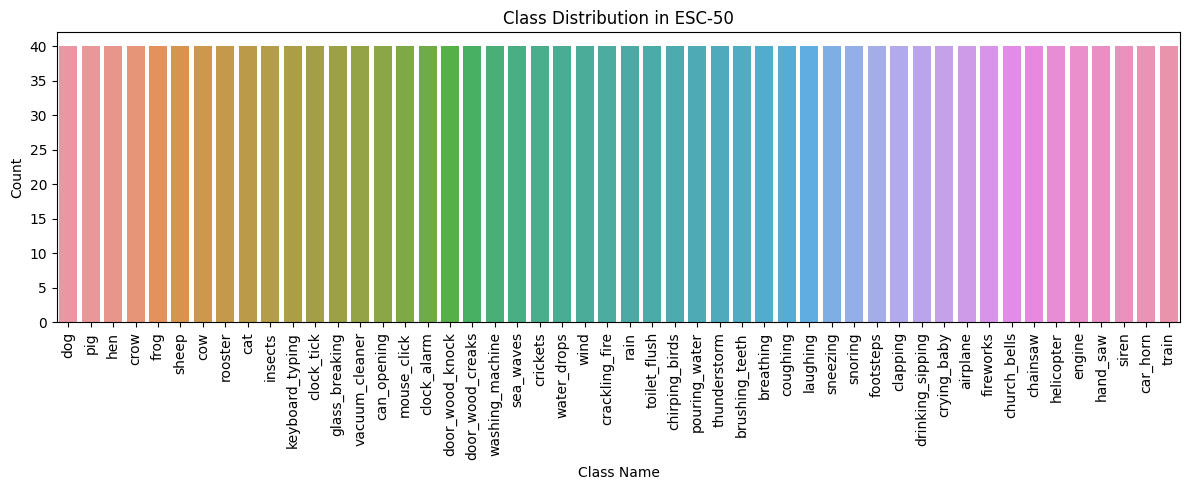


Plotting Major Category Distribution:


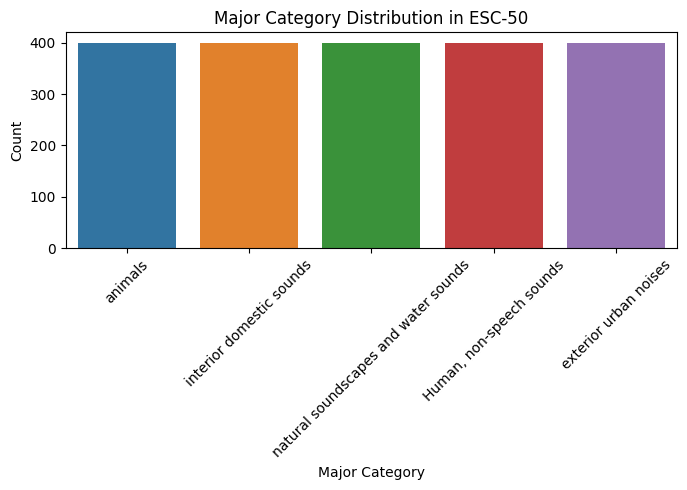


Displaying Audio Waveforms & Spectrograms Of Random Samples:


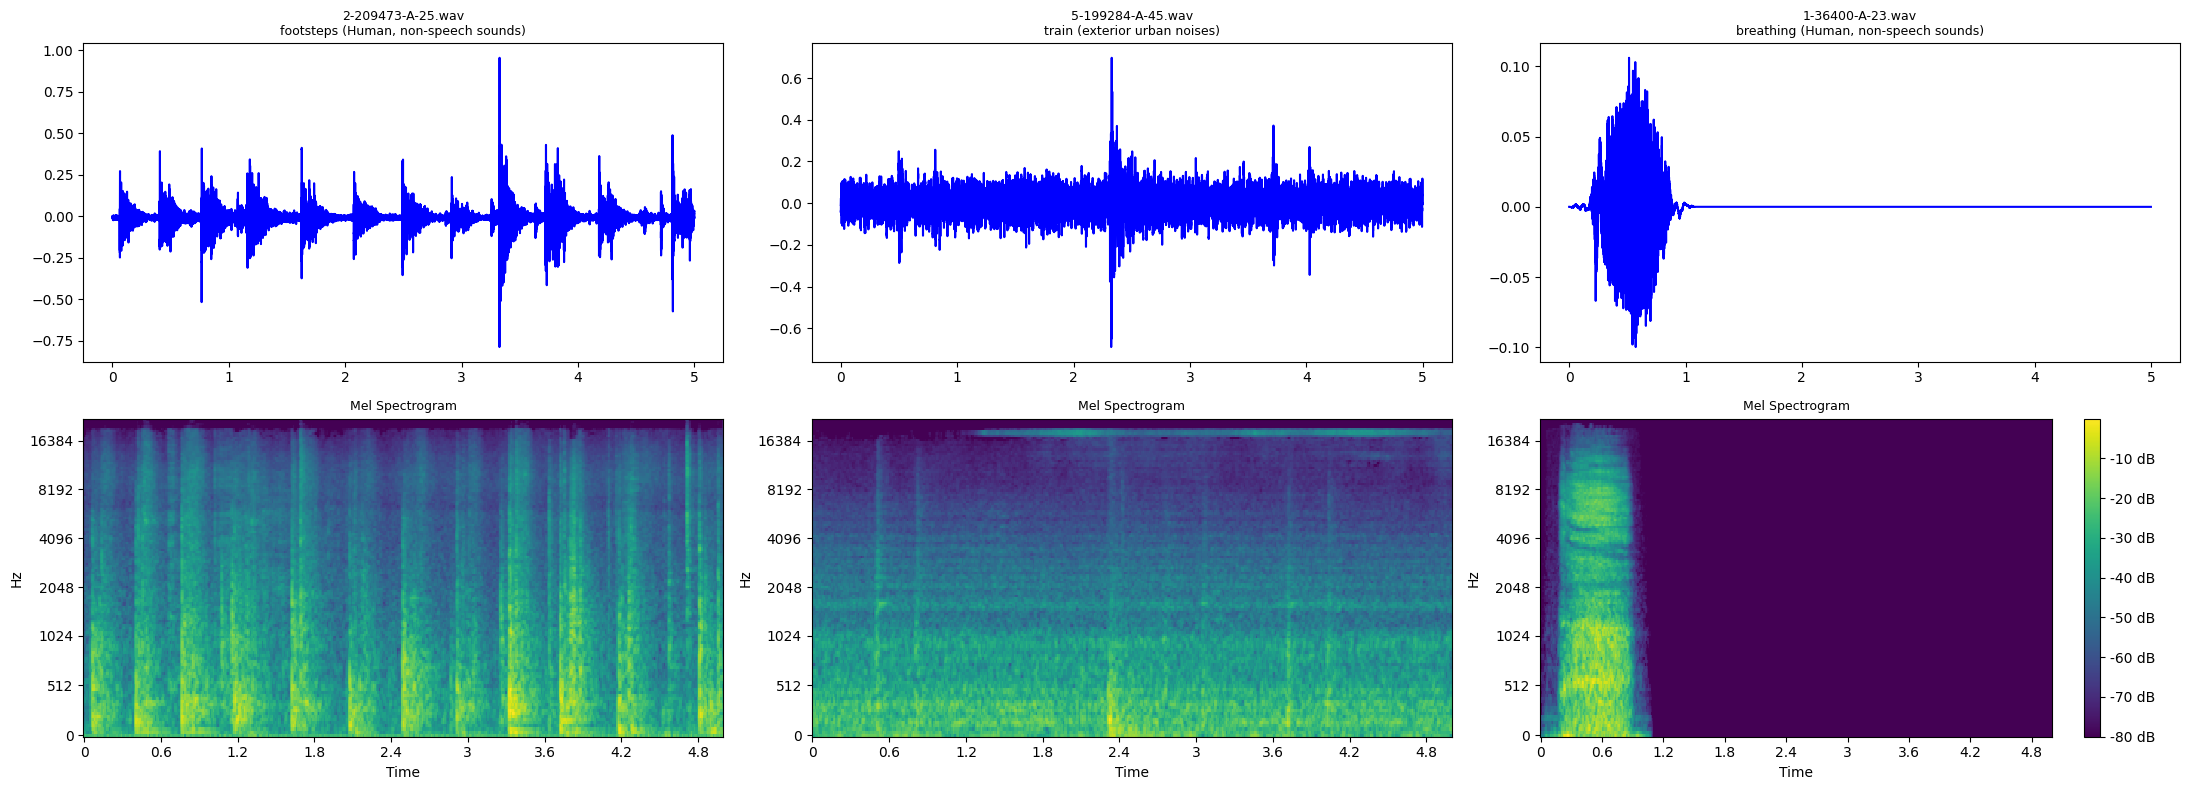


Detected 50 total unique classes: ['airplane', 'breathing', 'brushing_teeth', 'can_opening', 'car_horn', 'cat', 'chainsaw', 'chirping_birds', 'church_bells', 'clapping', 'clock_alarm', 'clock_tick', 'coughing', 'cow', 'crackling_fire', 'crickets', 'crow', 'crying_baby', 'dog', 'door_wood_creaks', 'door_wood_knock', 'drinking_sipping', 'engine', 'fireworks', 'footsteps', 'frog', 'glass_breaking', 'hand_saw', 'helicopter', 'hen', 'insects', 'keyboard_typing', 'laughing', 'mouse_click', 'pig', 'pouring_water', 'rain', 'rooster', 'sea_waves', 'sheep', 'siren', 'sneezing', 'snoring', 'thunderstorm', 'toilet_flush', 'train', 'vacuum_cleaner', 'washing_machine', 'water_drops', 'wind']


In [1]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as Models
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, average_precision_score
from tqdm import tqdm

RandomState = 2022484
np.random.seed(RandomState)
random.seed(RandomState)
torch.manual_seed(RandomState)
Device = torch.device("cuda")

def LoadMetaFromDirectory(DataDir):
    MetaData = []
    for MajorCategory in os.listdir(DataDir):
        MajorPath = os.path.join(DataDir, MajorCategory)
        if os.path.isdir(MajorPath):
            for ClassName in os.listdir(MajorPath):
                ClassPath = os.path.join(MajorPath, ClassName)
                if os.path.isdir(ClassPath):
                    for FileName in os.listdir(ClassPath):
                        if FileName.endswith(".wav"):
                            MetaData.append({
                                "filename": FileName,
                                "major_category": MajorCategory,
                                "class_name": ClassName,
                                "file_path": os.path.join(ClassPath, FileName)
                            })
    return pd.DataFrame(MetaData)

def PlotClassDistribution(MetaDf):
    plt.figure(figsize=(12, 5))
    sns.countplot(data=MetaDf, x="class_name", order=MetaDf["class_name"].value_counts().index)
    plt.title("Class Distribution in ESC-50")
    plt.xticks(rotation=90)
    plt.xlabel("Class Name")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

def PlotMajorCategoryDistribution(MetaDf):
    plt.figure(figsize=(7, 5))
    sns.countplot(data=MetaDf, x="major_category")
    plt.title("Major Category Distribution in ESC-50")
    plt.xticks(rotation=45)
    plt.xlabel("Major Category")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

def DisplayRandomAudios(MetaDf, NumSamples=6):
    RandomFiles = MetaDf.sample(NumSamples, random_state=RandomState)
    Fig, Axes = plt.subplots(2, NumSamples, figsize=(22, 8))
    
    for i, (_, Row) in enumerate(RandomFiles.iterrows()):
        FilePath = Row["file_path"]
        FileName = Row["filename"]
        ClassName = Row["class_name"]
        MajorCategory = Row["major_category"]

        Signal, Sr = librosa.load(FilePath, sr=None)
        MelSpec = librosa.feature.melspectrogram(
            y=Signal, sr=Sr, n_fft=2048, hop_length=512, n_mels=128
        )
        MelSpecDb = librosa.power_to_db(MelSpec, ref=np.max)

        Axes[0, i].plot(np.linspace(0, len(Signal) / Sr, len(Signal)), Signal, color="b")
        Axes[0, i].set_title(f"{FileName}\n{ClassName} ({MajorCategory})", fontsize=9)
        Axes[0, i].axis("tight")

        Img = librosa.display.specshow(
            MelSpecDb, sr=Sr, hop_length=512, x_axis="time", y_axis="mel",
            cmap="viridis", ax=Axes[1, i]
        )
        Axes[1, i].set_title("Mel Spectrogram", fontsize=9)
        if i == NumSamples - 1:
            Fig.colorbar(Img, ax=Axes[1, i], format="%+2.0f dB")

    plt.tight_layout()
    plt.show()

def SplitTrainValTest(MetaDf, ValRatio=0.1, TestRatio=0.1):
    TrainRatio = 1.0 - (ValRatio + TestRatio)
    TrainDf, TempDf = train_test_split(
        MetaDf,
        test_size=(1 - TrainRatio),
        stratify=MetaDf["class_name"],
        random_state=RandomState
    )
    RelativeValRatio = ValRatio / (ValRatio + TestRatio)
    ValDf, TestDf = train_test_split(
        TempDf,
        test_size=(1 - RelativeValRatio),
        stratify=TempDf["class_name"],
        random_state=RandomState
    )
    return TrainDf, ValDf, TestDf

def FixedCountSplit(TrainDf, XPerClass):
    LabeledList = []
    UnlabeledList = []
    Grouped = TrainDf.groupby("class_name")
    for Cname, GroupDf in Grouped:
        GroupList = GroupDf.sample(frac=1, random_state=RandomState).values.tolist()
        if len(GroupList) <= XPerClass:
            LabeledList.extend(GroupList)
        else:
            LabeledList.extend(GroupList[:XPerClass])
            UnlabeledList.extend(GroupList[XPerClass:])
    LabeledCols = TrainDf.columns.tolist()
    UnlabeledCols = TrainDf.columns.tolist()

    LabeledDf = pd.DataFrame(LabeledList, columns=LabeledCols)
    UnlabeledDf = pd.DataFrame(UnlabeledList, columns=UnlabeledCols)
    return LabeledDf, UnlabeledDf


DataDir = "/kaggle/input/esc-50/esc_50"
MetaDf = LoadMetaFromDirectory(DataDir)

print("\nDataset Overview:")
print(MetaDf.head())
print(f"\nTotal number of recordings: {len(MetaDf)}")
print(f"Unique major categories: {MetaDf['major_category'].nunique()}")
print(f"Unique classes: {MetaDf['class_name'].nunique()}")

print("\nPlotting Class Distribution:")
PlotClassDistribution(MetaDf)

print("\nPlotting Major Category Distribution:")
PlotMajorCategoryDistribution(MetaDf)

print("\nDisplaying Audio Waveforms & Spectrograms Of Random Samples:")
DisplayRandomAudios(MetaDf, NumSamples=3)

TrainDf, ValDf, TestDf = SplitTrainValTest(MetaDf, ValRatio=0.1, TestRatio=0.1)

AllClasses = sorted(MetaDf["class_name"].unique())
print(f"\nDetected {len(AllClasses)} total unique classes:", AllClasses)

ResultsDict = {}
LabeledCounts = [5, 9, 17, 26]


In [ ]:
import os
import random
from collections import defaultdict
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18
from tqdm import tqdm
import librosa

### Utility Functions
def set_seed(seed=42):
    """Set random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def stratified_split(data, val_ratio=0.1):
    """Perform stratified split of data into training and validation sets."""
    paths = [item[0] for item in data]
    labels = [item[1] for item in data]
    sss = StratifiedShuffleSplit(n_splits=1, test_size=val_ratio, random_state=42)
    train_idx, val_idx = next(sss.split(paths, labels))
    train_data = [data[i] for i in train_idx]
    val_data = [data[i] for i in val_idx]
    return train_data, val_data

def create_unlabeled_data(data, unlabeled_ratio):
    """Mark a fraction of data as unlabeled by setting labels to -1."""
    data_by_class = defaultdict(list)
    for idx, (path, label) in enumerate(data):
        data_by_class[label].append(idx)
    new_data = data.copy()
    for label, indices in data_by_class.items():
        n = len(indices)
        n_unlabeled = int(np.round(unlabeled_ratio * n))
        unlabeled_indices = random.sample(indices, n_unlabeled)
        for idx in unlabeled_indices:
            new_data[idx] = (new_data[idx][0], -1)
    return new_data

def build_unlabeled_eval_list(train_id_data, ood_data, val_id_data, ood_pool_size=None):
    """Build evaluation lists for open-set detection."""
    train_unlabeled_eval = [(file, 1) for file, _ in train_id_data] + [(file, 0) for file, _ in ood_data]
    val_unlabeled_eval = [(file, 1) for file, _ in val_id_data]
    if ood_pool_size is None:
        ood_pool_size = len(val_id_data)
    val_ood_samples = random.sample([(file, 0) for file, _ in ood_data], min(len(ood_data), ood_pool_size))
    val_unlabeled_eval.extend(val_ood_samples)
    return train_unlabeled_eval, val_unlabeled_eval

### Data Loading and Preprocessing
def load_esc50_dataset(root_dir):
    """Load ESC-50 dataset from directory structure without a CSV file."""
    data = []
    class_to_idx = {}
    class_names = []

    # Walk through subdirectories (e.g., esc_50/animals/cow/)
    for root, dirs, files in os.walk(root_dir):
        for file_name in files:
            if file_name.endswith('.wav'):
                # Get the class name (e.g., 'cow' from 'esc_50/animals/cow')
                class_name = os.path.basename(os.path.dirname(os.path.join(root, file_name)))
                if class_name not in class_to_idx:
                    class_to_idx[class_name] = len(class_to_idx)
                    class_names.append(class_name)
                label = class_to_idx[class_name]
                file_path = os.path.join(root, file_name)
                data.append((file_path, label))

    print("All detected classes:", class_to_idx)

    # Define directories to be treated as OOD
    ood_dirs = [
        os.path.join(root_dir, 'interior domestic sounds'),
        os.path.join(root_dir, 'exterior urban noises')
    ]

    # Separate ID and OOD data based on directory
    id_data = []
    ood_data = []
    for file_path, label in data:
        class_name = class_names[label]
        # Check if the file belongs to an OOD directory
        is_ood = any(ood_dir in file_path for ood_dir in ood_dirs)
        if is_ood:
            ood_data.append((file_path, -1))
        else:
            id_data.append((file_path, label))

    # Remap ID labels to be contiguous
    id_labels = sorted(set(label for _, label in id_data))
    id_label_to_idx = {label: idx for idx, label in enumerate(id_labels)}
    id_data = [(file, id_label_to_idx[label]) for file, label in id_data]

    num_classes = len(id_label_to_idx)

    # Print classes after removing OOD
    id_class_names = [class_names[i] for i in id_labels]
    ood_class_names = [class_name for class_name, idx in class_to_idx.items() if idx not in id_labels]
    print("Detected ID classes after removing OOD:", {name: idx for idx, name in enumerate(id_class_names)})
    print("Detected OOD classes:", ood_class_names)

    return id_data, ood_data, num_classes

def compute_mel_spec(signal, sr=44100, n_mels=128, hop_length=512, n_fft=2048):
    """Compute Mel spectrogram from audio signal and resize to 128x128."""
    mel = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=n_mels, hop_length=hop_length, n_fft=n_fft)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    tensor = torch.tensor(mel_db).float()
    tensor = F.interpolate(tensor.unsqueeze(0).unsqueeze(0), size=(128, 128), mode='bilinear', align_corners=False)
    return tensor.squeeze(0).squeeze(0)

def audio_weak_transform(signal, sr):
    """Apply weak augmentation to audio signal."""
    if random.random() < 0.5:
        noise = np.random.normal(0, 1, len(signal))
        signal = signal + 0.02 * noise
    else:
        signal = librosa.effects.pitch_shift(signal, sr=sr, n_steps=random.uniform(-2, 2))
    return signal

def audio_strong_transform(signal, sr):
    """Apply strong augmentation to audio signal."""
    signal = signal + 0.05 * np.random.normal(0, 1, len(signal))
    signal = librosa.effects.pitch_shift(signal, sr=sr, n_steps=random.uniform(-5, 5))
    return signal

def spec_augment(mel_tensor, time_mask=25, freq_mask=12):
    """Apply SpecAugment to spectrogram (time and frequency masking)."""
    mel_aug = mel_tensor.clone()
    if mel_aug.shape[1] > time_mask:
        t0 = random.randint(0, mel_aug.shape[1] - time_mask)
        mel_aug[:, t0:t0 + time_mask] = 0
    if mel_aug.shape[0] > freq_mask:
        f0 = random.randint(0, mel_aug.shape[0] - freq_mask)
        mel_aug[f0:f0 + freq_mask, :] = 0
    return mel_aug

### Dataset Class
class ESC50Dataset(Dataset):
    def __init__(self, file_list, return_two_views=False, weak_transform=None, strong_transform=None, transform=None):
        self.file_list = file_list
        self.return_two_views = return_two_views
        self.weak_transform = weak_transform
        self.strong_transform = strong_transform
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        file_path, label = self.file_list[index]
        signal, sr = librosa.load(file_path, sr=44100)
        
        if self.return_two_views:
            # Unlabeled data: return weak and strong views
            sig_weak = self.weak_transform(signal, sr) if self.weak_transform else signal
            spec_weak = compute_mel_spec(sig_weak)
            sig_strong = self.strong_transform(signal, sr) if self.strong_transform else signal
            spec_strong = compute_mel_spec(sig_strong)
            spec_strong = spec_augment(spec_strong)
            return spec_weak.unsqueeze(0), spec_strong.unsqueeze(0), label
        else:
            # Labeled or validation data: return single view
            sig = self.transform(signal, sr) if self.transform else signal
            spec = compute_mel_spec(sig)
            return spec.unsqueeze(0), label

### Model Definition
class SeFOSS(nn.Module):
    def __init__(self, num_classes, proj_dim=128):
        super(SeFOSS, self).__init__()
        backbone = resnet18(pretrained=False)
        # Modify conv1 to accept single-channel input
        backbone.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.feature_extractor = nn.Sequential(*(list(backbone.children())[:-1]))
        self.feature_dim = backbone.fc.in_features
        self.classifier = nn.Linear(self.feature_dim, num_classes)
        self.projection = nn.Linear(self.feature_dim, proj_dim)

    def forward_backbone(self, x):
        features = self.feature_extractor(x)
        return features.view(x.size(0), -1)

    def forward(self, x):
        features = self.forward_backbone(x)
        features = self.dropout(features)
        logits = self.classifier(features)
        return logits

    def forward_features(self, x):
        features = self.forward_backbone(x)
        return self.dropout(features)

    def forward_projection(self, features):
        features = self.dropout(features)
        return self.projection(features)

### Loss Functions
def free_energy(logits):
    """Compute free energy for OOD detection."""
    return -torch.logsumexp(logits, dim=1)

def cosine_similarity_loss(f1, f2):
    """Compute cosine similarity loss for self-supervision."""
    f1_norm = F.normalize(f1, p=2, dim=1)
    f2_norm = F.normalize(f2, p=2, dim=1)
    return -(f1_norm * f2_norm).sum(dim=1).mean()

Detected classes: {'dog': 0, 'pig': 1, 'hen': 2, 'crow': 3, 'frog': 4, 'sheep': 5, 'cow': 6, 'rooster': 7, 'cat': 8, 'insects': 9, 'keyboard_typing': 10, 'clock_tick': 11, 'glass_breaking': 12, 'vacuum_cleaner': 13, 'can_opening': 14, 'mouse_click': 15, 'clock_alarm': 16, 'door_wood_knock': 17, 'door_wood_creaks': 18, 'washing_machine': 19, 'sea_waves': 20, 'crickets': 21, 'water_drops': 22, 'wind': 23, 'crackling_fire': 24, 'rain': 25, 'toilet_flush': 26, 'chirping_birds': 27, 'pouring_water': 28, 'thunderstorm': 29, 'brushing_teeth': 30, 'breathing': 31, 'coughing': 32, 'laughing': 33, 'sneezing': 34, 'snoring': 35, 'footsteps': 36, 'clapping': 37, 'drinking_sipping': 38, 'crying_baby': 39, 'airplane': 40, 'fireworks': 41, 'church_bells': 42, 'chainsaw': 43, 'helicopter': 44, 'engine': 45, 'hand_saw': 46, 'siren': 47, 'car_horn': 48, 'train': 49}


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Epoch [1/30]: 100%|██████████| 59/59 [03:33<00:00,  3.62s/it, loss=2.58]


[Epoch 1] Train Loss: 2.5805, Train Acc: 38.34%, Val Loss: 2.8993, Val Acc: 15.83%, AUROC (Train): 0.5183, AUROC (Val): 0.5316


Epoch [2/30]: 100%|██████████| 59/59 [03:27<00:00,  3.52s/it, loss=0.396]


[Epoch 2] Train Loss: 0.7910, Train Acc: 87.56%, Val Loss: 2.5065, Val Acc: 30.83%, AUROC (Train): 0.5353, AUROC (Val): 0.5421


Epoch [3/30]: 100%|██████████| 59/59 [03:27<00:00,  3.51s/it, loss=0.0353]


[Epoch 3] Train Loss: 0.1058, Train Acc: 98.20%, Val Loss: 2.6725, Val Acc: 27.50%, AUROC (Train): 0.5243, AUROC (Val): 0.5420


Epoch [4/30]: 100%|██████████| 59/59 [03:29<00:00,  3.55s/it, loss=-0.00139] 


[Epoch 4] Train Loss: -0.0056, Train Acc: 99.04%, Val Loss: 2.4790, Val Acc: 34.17%, AUROC (Train): 0.5459, AUROC (Val): 0.5387


Epoch [5/30]: 100%|██████████| 59/59 [03:26<00:00,  3.51s/it, loss=-0.00848] 


[Epoch 5] Train Loss: -0.0424, Train Acc: 99.72%, Val Loss: 2.3011, Val Acc: 38.33%, AUROC (Train): 0.5584, AUROC (Val): 0.5345


Epoch [6/30]: 100%|██████████| 59/59 [03:29<00:00,  3.55s/it, loss=0.244] 


[Epoch 6] Train Loss: 1.4624, Train Acc: 89.53%, Val Loss: 3.2036, Val Acc: 25.83%, AUROC (Train): 0.5454, AUROC (Val): 0.4678


Epoch [7/30]: 100%|██████████| 59/59 [03:24<00:00,  3.47s/it, loss=0.171] 


[Epoch 7] Train Loss: 1.2004, Train Acc: 84.23%, Val Loss: 3.7292, Val Acc: 23.33%, AUROC (Train): 0.4709, AUROC (Val): 0.4507
tau_id: -6.592096495628357
tau_ood: -3.9529768109321592
margin_ood: -2.8973289370536808
✅ Saved best model.


Epoch [8/30]: 100%|██████████| 59/59 [03:26<00:00,  3.49s/it, loss=0.123] 


[Epoch 8] Train Loss: 0.9861, Train Acc: 84.57%, Val Loss: 3.0093, Val Acc: 30.00%, AUROC (Train): 0.5430, AUROC (Val): 0.4917
tau_id: -6.592096495628357
tau_ood: -3.9529768109321592
margin_ood: -2.8973289370536808
✅ Saved best model.


Epoch [9/30]: 100%|██████████| 59/59 [03:21<00:00,  3.42s/it, loss=0.0597] 


[Epoch 9] Train Loss: 0.5376, Train Acc: 90.88%, Val Loss: 3.8881, Val Acc: 31.67%, AUROC (Train): 0.5083, AUROC (Val): 0.4901
tau_id: -6.592096495628357
tau_ood: -3.9529768109321592
margin_ood: -2.8973289370536808
✅ Saved best model.


Epoch [10/30]: 100%|██████████| 59/59 [03:19<00:00,  3.38s/it, loss=0.0885]


[Epoch 10] Train Loss: 0.8848, Train Acc: 88.85%, Val Loss: 3.0697, Val Acc: 30.83%, AUROC (Train): 0.5232, AUROC (Val): 0.5108


Epoch [11/30]: 100%|██████████| 59/59 [03:17<00:00,  3.36s/it, loss=0.0618] 


[Epoch 11] Train Loss: 0.6797, Train Acc: 90.65%, Val Loss: 3.1401, Val Acc: 30.83%, AUROC (Train): 0.4841, AUROC (Val): 0.4261


Epoch [12/30]: 100%|██████████| 59/59 [03:23<00:00,  3.45s/it, loss=0.0697] 


[Epoch 12] Train Loss: 0.8360, Train Acc: 89.75%, Val Loss: 3.7472, Val Acc: 30.00%, AUROC (Train): 0.5116, AUROC (Val): 0.4844


Epoch [13/30]: 100%|██████████| 59/59 [03:17<00:00,  3.35s/it, loss=0.0349] 


[Epoch 13] Train Loss: 0.4536, Train Acc: 93.58%, Val Loss: 4.0642, Val Acc: 26.67%, AUROC (Train): 0.5716, AUROC (Val): 0.5106


Epoch [14/30]: 100%|██████████| 59/59 [03:25<00:00,  3.48s/it, loss=0.0414] 


[Epoch 14] Train Loss: 0.5794, Train Acc: 90.65%, Val Loss: 3.1281, Val Acc: 32.50%, AUROC (Train): 0.5357, AUROC (Val): 0.4544
tau_id: -6.592096495628357
tau_ood: -3.9529768109321592
margin_ood: -2.8973289370536808
✅ Saved best model.


Epoch [15/30]: 100%|██████████| 59/59 [03:25<00:00,  3.48s/it, loss=0.0585] 


[Epoch 15] Train Loss: 0.8775, Train Acc: 89.41%, Val Loss: 3.4885, Val Acc: 34.17%, AUROC (Train): 0.5377, AUROC (Val): 0.5026
tau_id: -6.592096495628357
tau_ood: -3.9529768109321592
margin_ood: -2.8973289370536808
✅ Saved best model.


Epoch [16/30]: 100%|██████████| 59/59 [03:23<00:00,  3.45s/it, loss=0.0292] 


[Epoch 16] Train Loss: 0.4672, Train Acc: 92.06%, Val Loss: 3.1195, Val Acc: 36.67%, AUROC (Train): 0.5469, AUROC (Val): 0.4898
tau_id: -6.592096495628357
tau_ood: -3.9529768109321592
margin_ood: -2.8973289370536808
✅ Saved best model.


Epoch [17/30]: 100%|██████████| 59/59 [03:24<00:00,  3.47s/it, loss=0.0309] 


[Epoch 17] Train Loss: 0.5249, Train Acc: 95.50%, Val Loss: 3.2177, Val Acc: 34.17%, AUROC (Train): 0.5830, AUROC (Val): 0.5343


Epoch [18/30]: 100%|██████████| 59/59 [03:22<00:00,  3.43s/it, loss=0.0389]


[Epoch 18] Train Loss: 0.7004, Train Acc: 91.84%, Val Loss: 4.5641, Val Acc: 24.17%, AUROC (Train): 0.4895, AUROC (Val): 0.4210


Epoch [19/30]: 100%|██████████| 59/59 [03:22<00:00,  3.44s/it, loss=0.0173] 


[Epoch 19] Train Loss: 0.3289, Train Acc: 96.17%, Val Loss: 3.9787, Val Acc: 29.17%, AUROC (Train): 0.5511, AUROC (Val): 0.4989


Epoch [20/30]: 100%|██████████| 59/59 [03:22<00:00,  3.43s/it, loss=0.00876]


[Epoch 20] Train Loss: 0.1751, Train Acc: 96.34%, Val Loss: 3.2903, Val Acc: 37.50%, AUROC (Train): 0.5878, AUROC (Val): 0.5049
tau_id: -6.592096495628357
tau_ood: -3.9529768109321592
margin_ood: -2.8973289370536808
✅ Saved best model.


Epoch [21/30]: 100%|██████████| 59/59 [03:29<00:00,  3.55s/it, loss=0.0103]  


[Epoch 21] Train Loss: 0.2165, Train Acc: 98.54%, Val Loss: 3.2256, Val Acc: 34.17%, AUROC (Train): 0.5917, AUROC (Val): 0.5147


Epoch [22/30]: 100%|██████████| 59/59 [03:26<00:00,  3.50s/it, loss=0.00327]  


[Epoch 22] Train Loss: 0.0719, Train Acc: 99.16%, Val Loss: 4.2375, Val Acc: 32.50%, AUROC (Train): 0.5885, AUROC (Val): 0.5060


Epoch [23/30]: 100%|██████████| 59/59 [03:28<00:00,  3.54s/it, loss=0.0122]  


[Epoch 23] Train Loss: 0.2813, Train Acc: 97.18%, Val Loss: 3.6573, Val Acc: 35.00%, AUROC (Train): 0.5863, AUROC (Val): 0.5612


Epoch [24/30]: 100%|██████████| 59/59 [03:26<00:00,  3.50s/it, loss=0.0155] 


[Epoch 24] Train Loss: 0.3720, Train Acc: 94.48%, Val Loss: 3.7570, Val Acc: 36.67%, AUROC (Train): 0.5495, AUROC (Val): 0.4756


Epoch [25/30]: 100%|██████████| 59/59 [03:25<00:00,  3.48s/it, loss=0.0126] 


[Epoch 25] Train Loss: 0.3146, Train Acc: 96.11%, Val Loss: 3.5899, Val Acc: 34.17%, AUROC (Train): 0.5805, AUROC (Val): 0.4855


Epoch [26/30]: 100%|██████████| 59/59 [03:20<00:00,  3.40s/it, loss=0.00661]


[Epoch 26] Train Loss: 0.1718, Train Acc: 98.93%, Val Loss: 3.6404, Val Acc: 35.00%, AUROC (Train): 0.5803, AUROC (Val): 0.5326


Epoch [27/30]: 100%|██████████| 59/59 [03:23<00:00,  3.44s/it, loss=0.00661] 


[Epoch 27] Train Loss: 0.1784, Train Acc: 98.31%, Val Loss: 3.3279, Val Acc: 35.83%, AUROC (Train): 0.5584, AUROC (Val): 0.4340


Epoch [28/30]: 100%|██████████| 59/59 [03:20<00:00,  3.40s/it, loss=-0.000579]


[Epoch 28] Train Loss: -0.0162, Train Acc: 99.77%, Val Loss: 3.1116, Val Acc: 37.50%, AUROC (Train): 0.5854, AUROC (Val): 0.5033


Epoch [29/30]: 100%|██████████| 59/59 [03:18<00:00,  3.36s/it, loss=-0.000719]


[Epoch 29] Train Loss: -0.0208, Train Acc: 99.44%, Val Loss: 3.1143, Val Acc: 36.67%, AUROC (Train): 0.5951, AUROC (Val): 0.5213


Epoch [30/30]: 100%|██████████| 59/59 [03:25<00:00,  3.48s/it, loss=0.00406] 


[Epoch 30] Train Loss: 0.1218, Train Acc: 99.55%, Val Loss: 3.4213, Val Acc: 33.33%, AUROC (Train): 0.5885, AUROC (Val): 0.5162


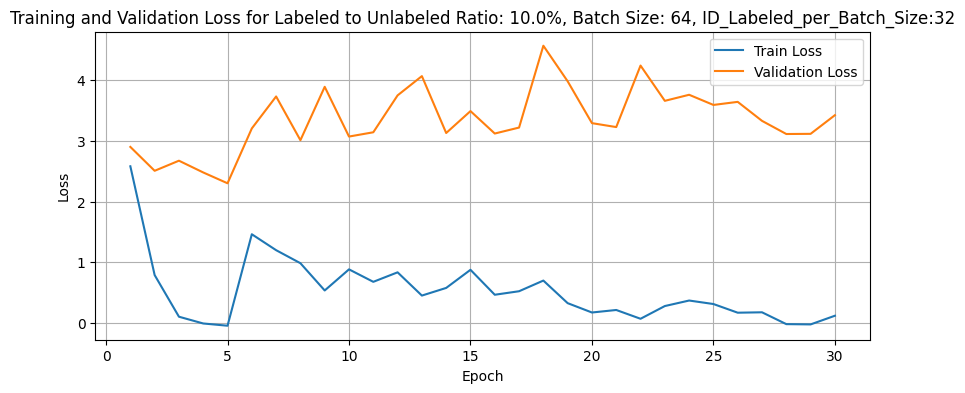

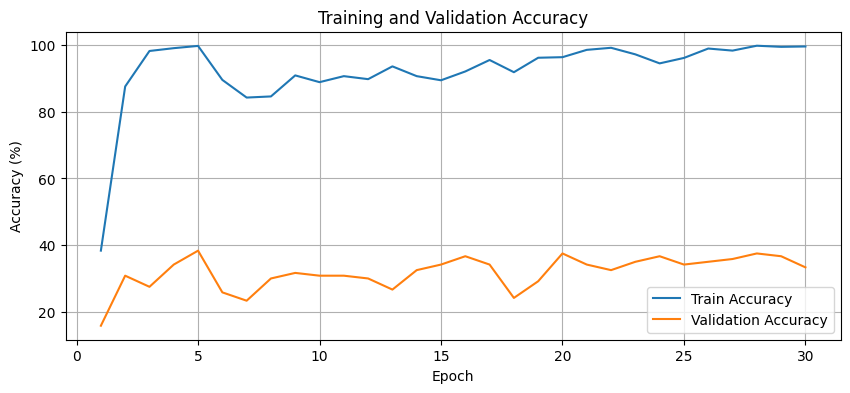

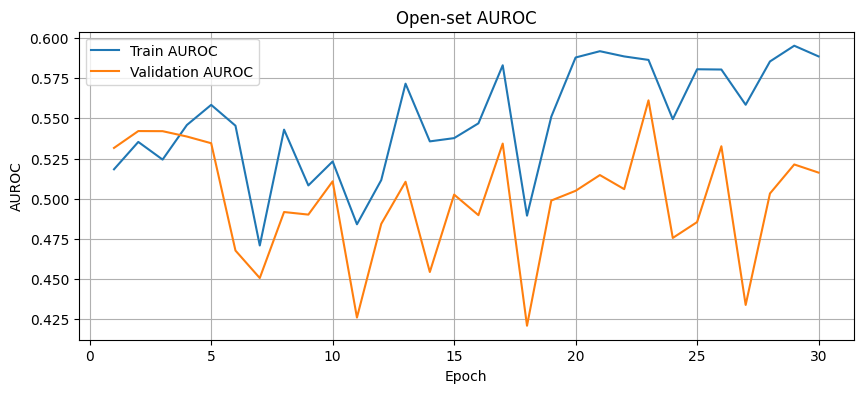

🎉 Training complete.
Detected classes: {'dog': 0, 'pig': 1, 'hen': 2, 'crow': 3, 'frog': 4, 'sheep': 5, 'cow': 6, 'rooster': 7, 'cat': 8, 'insects': 9, 'keyboard_typing': 10, 'clock_tick': 11, 'glass_breaking': 12, 'vacuum_cleaner': 13, 'can_opening': 14, 'mouse_click': 15, 'clock_alarm': 16, 'door_wood_knock': 17, 'door_wood_creaks': 18, 'washing_machine': 19, 'sea_waves': 20, 'crickets': 21, 'water_drops': 22, 'wind': 23, 'crackling_fire': 24, 'rain': 25, 'toilet_flush': 26, 'chirping_birds': 27, 'pouring_water': 28, 'thunderstorm': 29, 'brushing_teeth': 30, 'breathing': 31, 'coughing': 32, 'laughing': 33, 'sneezing': 34, 'snoring': 35, 'footsteps': 36, 'clapping': 37, 'drinking_sipping': 38, 'crying_baby': 39, 'airplane': 40, 'fireworks': 41, 'church_bells': 42, 'chainsaw': 43, 'helicopter': 44, 'engine': 45, 'hand_saw': 46, 'siren': 47, 'car_horn': 48, 'train': 49}


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Epoch [1/30]: 100%|██████████| 24/24 [03:03<00:00,  7.63s/it, loss=3.11]


[Epoch 1] Train Loss: 3.1051, Train Acc: 15.73%, Val Loss: 3.1955, Val Acc: 11.67%, AUROC (Train): 0.5253, AUROC (Val): 0.5077


Epoch [2/30]: 100%|██████████| 24/24 [02:58<00:00,  7.43s/it, loss=1.15] 


[Epoch 2] Train Loss: 2.2964, Train Acc: 51.04%, Val Loss: 2.7582, Val Acc: 25.00%, AUROC (Train): 0.5176, AUROC (Val): 0.5221


Epoch [3/30]: 100%|██████████| 24/24 [02:57<00:00,  7.40s/it, loss=0.471]


[Epoch 3] Train Loss: 1.4123, Train Acc: 76.98%, Val Loss: 2.8473, Val Acc: 24.17%, AUROC (Train): 0.5225, AUROC (Val): 0.5490


Epoch [4/30]: 100%|██████████| 24/24 [02:59<00:00,  7.49s/it, loss=0.176]


[Epoch 4] Train Loss: 0.7041, Train Acc: 90.21%, Val Loss: 2.6612, Val Acc: 25.83%, AUROC (Train): 0.5306, AUROC (Val): 0.5410


Epoch [5/30]: 100%|██████████| 24/24 [02:59<00:00,  7.47s/it, loss=0.071] 


[Epoch 5] Train Loss: 0.3549, Train Acc: 95.00%, Val Loss: 2.5298, Val Acc: 30.83%, AUROC (Train): 0.5353, AUROC (Val): 0.5482


Epoch [6/30]: 100%|██████████| 24/24 [02:56<00:00,  7.36s/it, loss=0.265]


[Epoch 6] Train Loss: 1.5917, Train Acc: 92.81%, Val Loss: 2.4790, Val Acc: 35.83%, AUROC (Train): 0.5026, AUROC (Val): 0.4451


Epoch [7/30]: 100%|██████████| 24/24 [03:01<00:00,  7.56s/it, loss=0.184] 


[Epoch 7] Train Loss: 1.2863, Train Acc: 96.15%, Val Loss: 2.9247, Val Acc: 30.00%, AUROC (Train): 0.4733, AUROC (Val): 0.4519
tau_id: -5.337637710571289
tau_ood: -3.571830081939697
margin_ood: -2.8655070304870605
✅ Saved best model.


Epoch [8/30]: 100%|██████████| 24/24 [03:02<00:00,  7.62s/it, loss=0.135] 


[Epoch 8] Train Loss: 1.0816, Train Acc: 97.40%, Val Loss: 2.5018, Val Acc: 40.00%, AUROC (Train): 0.5147, AUROC (Val): 0.4518
tau_id: -5.337637710571289
tau_ood: -3.571830081939697
margin_ood: -2.8655070304870605
✅ Saved best model.


Epoch [9/30]: 100%|██████████| 24/24 [02:59<00:00,  7.47s/it, loss=0.105] 


[Epoch 9] Train Loss: 0.9491, Train Acc: 98.33%, Val Loss: 2.8371, Val Acc: 39.17%, AUROC (Train): 0.4905, AUROC (Val): 0.4422


Epoch [10/30]: 100%|██████████| 24/24 [03:02<00:00,  7.59s/it, loss=0.0879]


[Epoch 10] Train Loss: 0.8789, Train Acc: 98.65%, Val Loss: 2.9375, Val Acc: 35.83%, AUROC (Train): 0.4836, AUROC (Val): 0.3831


Epoch [11/30]: 100%|██████████| 24/24 [02:58<00:00,  7.43s/it, loss=0.0774]


[Epoch 11] Train Loss: 0.8518, Train Acc: 99.17%, Val Loss: 2.8828, Val Acc: 37.50%, AUROC (Train): 0.4750, AUROC (Val): 0.3692


Epoch [12/30]: 100%|██████████| 24/24 [03:00<00:00,  7.53s/it, loss=0.0697]


[Epoch 12] Train Loss: 0.8368, Train Acc: 99.48%, Val Loss: 2.7067, Val Acc: 39.17%, AUROC (Train): 0.4758, AUROC (Val): 0.3531


Epoch [13/30]: 100%|██████████| 24/24 [03:00<00:00,  7.50s/it, loss=0.0599]


[Epoch 13] Train Loss: 0.7787, Train Acc: 99.06%, Val Loss: 2.8733, Val Acc: 37.50%, AUROC (Train): 0.4826, AUROC (Val): 0.3658


Epoch [14/30]: 100%|██████████| 24/24 [02:55<00:00,  7.33s/it, loss=0.0551]


[Epoch 14] Train Loss: 0.7714, Train Acc: 99.48%, Val Loss: 3.0676, Val Acc: 35.00%, AUROC (Train): 0.4694, AUROC (Val): 0.3776


Epoch [15/30]: 100%|██████████| 24/24 [02:55<00:00,  7.32s/it, loss=0.0494]


[Epoch 15] Train Loss: 0.7406, Train Acc: 99.58%, Val Loss: 2.8293, Val Acc: 36.67%, AUROC (Train): 0.4676, AUROC (Val): 0.3680


Epoch [16/30]: 100%|██████████| 24/24 [02:57<00:00,  7.40s/it, loss=0.0453]


[Epoch 16] Train Loss: 0.7250, Train Acc: 99.79%, Val Loss: 3.2012, Val Acc: 39.17%, AUROC (Train): 0.4980, AUROC (Val): 0.3928


Epoch [17/30]: 100%|██████████| 24/24 [02:55<00:00,  7.31s/it, loss=0.0424]


[Epoch 17] Train Loss: 0.7205, Train Acc: 99.79%, Val Loss: 2.6670, Val Acc: 43.33%, AUROC (Train): 0.4976, AUROC (Val): 0.3974
tau_id: -5.337637710571289
tau_ood: -3.571830081939697
margin_ood: -2.8655070304870605
✅ Saved best model.


Epoch [18/30]: 100%|██████████| 24/24 [02:58<00:00,  7.43s/it, loss=0.0401]


[Epoch 18] Train Loss: 0.7212, Train Acc: 99.48%, Val Loss: 2.7168, Val Acc: 41.67%, AUROC (Train): 0.5009, AUROC (Val): 0.4015


Epoch [19/30]: 100%|██████████| 24/24 [02:59<00:00,  7.49s/it, loss=0.0382]


[Epoch 19] Train Loss: 0.7256, Train Acc: 99.79%, Val Loss: 2.6323, Val Acc: 41.67%, AUROC (Train): 0.5086, AUROC (Val): 0.4099


Epoch [20/30]: 100%|██████████| 24/24 [03:02<00:00,  7.61s/it, loss=0.0346]


[Epoch 20] Train Loss: 0.6926, Train Acc: 99.48%, Val Loss: 2.7617, Val Acc: 40.83%, AUROC (Train): 0.4839, AUROC (Val): 0.3752


Epoch [21/30]: 100%|██████████| 24/24 [02:59<00:00,  7.48s/it, loss=0.0335]


[Epoch 21] Train Loss: 0.7040, Train Acc: 100.00%, Val Loss: 2.7098, Val Acc: 44.17%, AUROC (Train): 0.5053, AUROC (Val): 0.4019
tau_id: -5.337637710571289
tau_ood: -3.571830081939697
margin_ood: -2.8655070304870605
✅ Saved best model.


Epoch [22/30]: 100%|██████████| 24/24 [03:01<00:00,  7.56s/it, loss=0.0301]


[Epoch 22] Train Loss: 0.6632, Train Acc: 100.00%, Val Loss: 2.5595, Val Acc: 43.33%, AUROC (Train): 0.4965, AUROC (Val): 0.3842


Epoch [23/30]: 100%|██████████| 24/24 [03:01<00:00,  7.55s/it, loss=0.0285]


[Epoch 23] Train Loss: 0.6559, Train Acc: 100.00%, Val Loss: 2.8730, Val Acc: 32.50%, AUROC (Train): 0.4572, AUROC (Val): 0.3492


Epoch [24/30]: 100%|██████████| 24/24 [02:59<00:00,  7.49s/it, loss=0.0273]


[Epoch 24] Train Loss: 0.6547, Train Acc: 99.90%, Val Loss: 2.6617, Val Acc: 41.67%, AUROC (Train): 0.5128, AUROC (Val): 0.4126


Epoch [25/30]: 100%|██████████| 24/24 [02:59<00:00,  7.48s/it, loss=0.0263]


[Epoch 25] Train Loss: 0.6582, Train Acc: 99.69%, Val Loss: 2.8183, Val Acc: 41.67%, AUROC (Train): 0.5199, AUROC (Val): 0.4380


Epoch [26/30]: 100%|██████████| 24/24 [02:59<00:00,  7.48s/it, loss=0.0233] 


[Epoch 26] Train Loss: 0.6051, Train Acc: 100.00%, Val Loss: 2.9669, Val Acc: 36.67%, AUROC (Train): 0.4965, AUROC (Val): 0.4162


Epoch [27/30]: 100%|██████████| 24/24 [02:57<00:00,  7.40s/it, loss=0.022]  


[Epoch 27] Train Loss: 0.5944, Train Acc: 100.00%, Val Loss: 2.7419, Val Acc: 40.00%, AUROC (Train): 0.4735, AUROC (Val): 0.3826


Epoch [28/30]: 100%|██████████| 24/24 [02:59<00:00,  7.48s/it, loss=0.0227] 


[Epoch 28] Train Loss: 0.6361, Train Acc: 99.90%, Val Loss: 2.8214, Val Acc: 39.17%, AUROC (Train): 0.5043, AUROC (Val): 0.4284


Epoch [29/30]: 100%|██████████| 24/24 [02:57<00:00,  7.39s/it, loss=0.021]  


[Epoch 29] Train Loss: 0.6096, Train Acc: 100.00%, Val Loss: 2.6951, Val Acc: 40.83%, AUROC (Train): 0.4917, AUROC (Val): 0.4024


Epoch [30/30]: 100%|██████████| 24/24 [03:01<00:00,  7.55s/it, loss=0.0205] 


[Epoch 30] Train Loss: 0.6139, Train Acc: 99.69%, Val Loss: 2.6819, Val Acc: 46.67%, AUROC (Train): 0.5067, AUROC (Val): 0.4183
tau_id: -5.337637710571289
tau_ood: -3.571830081939697
margin_ood: -2.8655070304870605
✅ Saved best model.


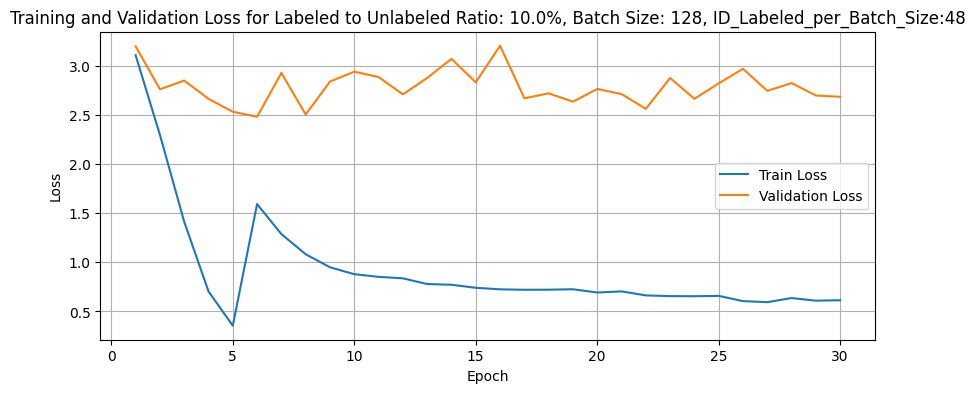

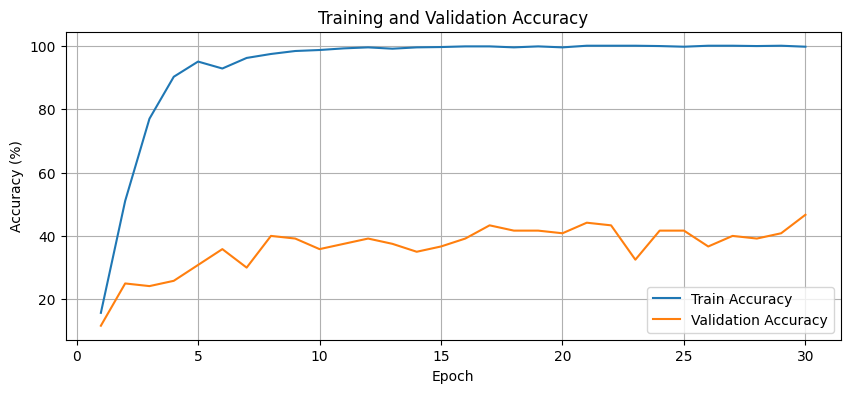

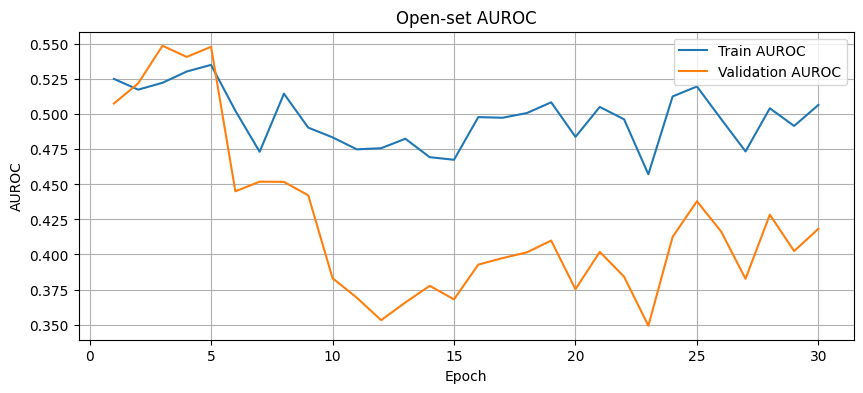

🎉 Training complete.
Detected classes: {'dog': 0, 'pig': 1, 'hen': 2, 'crow': 3, 'frog': 4, 'sheep': 5, 'cow': 6, 'rooster': 7, 'cat': 8, 'insects': 9, 'keyboard_typing': 10, 'clock_tick': 11, 'glass_breaking': 12, 'vacuum_cleaner': 13, 'can_opening': 14, 'mouse_click': 15, 'clock_alarm': 16, 'door_wood_knock': 17, 'door_wood_creaks': 18, 'washing_machine': 19, 'sea_waves': 20, 'crickets': 21, 'water_drops': 22, 'wind': 23, 'crackling_fire': 24, 'rain': 25, 'toilet_flush': 26, 'chirping_birds': 27, 'pouring_water': 28, 'thunderstorm': 29, 'brushing_teeth': 30, 'breathing': 31, 'coughing': 32, 'laughing': 33, 'sneezing': 34, 'snoring': 35, 'footsteps': 36, 'clapping': 37, 'drinking_sipping': 38, 'crying_baby': 39, 'airplane': 40, 'fireworks': 41, 'church_bells': 42, 'chainsaw': 43, 'helicopter': 44, 'engine': 45, 'hand_saw': 46, 'siren': 47, 'car_horn': 48, 'train': 49}


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Epoch [1/30]: 100%|██████████| 30/30 [03:23<00:00,  6.79s/it, loss=2.92]


[Epoch 1] Train Loss: 2.9162, Train Acc: 28.50%, Val Loss: 2.9060, Val Acc: 17.50%, AUROC (Train): 0.5253, AUROC (Val): 0.5119


Epoch [4/30]: 100%|██████████| 30/30 [03:19<00:00,  6.64s/it, loss=0.0715]


[Epoch 4] Train Loss: 0.2861, Train Acc: 97.67%, Val Loss: 2.5278, Val Acc: 30.00%, AUROC (Train): 0.5241, AUROC (Val): 0.5495


Epoch [5/30]: 100%|██████████| 30/30 [03:19<00:00,  6.65s/it, loss=0.0132] 


[Epoch 5] Train Loss: 0.0658, Train Acc: 99.72%, Val Loss: 2.3526, Val Acc: 34.17%, AUROC (Train): 0.5344, AUROC (Val): 0.5369


Epoch [6/30]: 100%|██████████| 30/30 [03:23<00:00,  6.77s/it, loss=0.231]


[Epoch 6] Train Loss: 1.3831, Train Acc: 96.78%, Val Loss: 2.4299, Val Acc: 28.33%, AUROC (Train): 0.5068, AUROC (Val): 0.4685


Epoch [7/30]: 100%|██████████| 30/30 [03:23<00:00,  6.77s/it, loss=0.13]  


[Epoch 7] Train Loss: 0.9113, Train Acc: 93.44%, Val Loss: 2.8131, Val Acc: 25.00%, AUROC (Train): 0.4986, AUROC (Val): 0.4923
tau_id: -5.732638430595398
tau_ood: -3.882020962238312
margin_ood: -3.1417739748954774
✅ Saved best model.


Epoch [8/30]: 100%|██████████| 30/30 [03:24<00:00,  6.82s/it, loss=0.104] 


[Epoch 8] Train Loss: 0.8348, Train Acc: 94.00%, Val Loss: 3.3573, Val Acc: 28.33%, AUROC (Train): 0.5215, AUROC (Val): 0.5268
tau_id: -5.732638430595398
tau_ood: -3.882020962238312
margin_ood: -3.1417739748954774
✅ Saved best model.


Epoch [9/30]: 100%|██████████| 30/30 [03:27<00:00,  6.91s/it, loss=0.129] 


[Epoch 9] Train Loss: 1.1606, Train Acc: 87.44%, Val Loss: 3.5777, Val Acc: 22.50%, AUROC (Train): 0.5257, AUROC (Val): 0.4987


Epoch [10/30]: 100%|██████████| 30/30 [03:27<00:00,  6.92s/it, loss=0.105] 


[Epoch 10] Train Loss: 1.0528, Train Acc: 91.22%, Val Loss: 3.5138, Val Acc: 26.67%, AUROC (Train): 0.5138, AUROC (Val): 0.4459


Epoch [11/30]: 100%|██████████| 30/30 [03:25<00:00,  6.85s/it, loss=0.0642]


[Epoch 11] Train Loss: 0.7059, Train Acc: 94.78%, Val Loss: 3.1959, Val Acc: 30.83%, AUROC (Train): 0.5134, AUROC (Val): 0.4387
tau_id: -5.732638430595398
tau_ood: -3.882020962238312
margin_ood: -3.1417739748954774
✅ Saved best model.


Epoch [12/30]: 100%|██████████| 30/30 [03:24<00:00,  6.81s/it, loss=0.0574] 


[Epoch 12] Train Loss: 0.6883, Train Acc: 95.50%, Val Loss: 3.3824, Val Acc: 30.83%, AUROC (Train): 0.4989, AUROC (Val): 0.4410


Epoch [13/30]: 100%|██████████| 30/30 [03:22<00:00,  6.74s/it, loss=0.0365]


[Epoch 13] Train Loss: 0.4739, Train Acc: 96.61%, Val Loss: 2.9942, Val Acc: 30.00%, AUROC (Train): 0.5018, AUROC (Val): 0.4194


Epoch [14/30]: 100%|██████████| 30/30 [03:26<00:00,  6.89s/it, loss=0.0346] 


[Epoch 14] Train Loss: 0.4839, Train Acc: 97.78%, Val Loss: 3.3539, Val Acc: 34.17%, AUROC (Train): 0.4955, AUROC (Val): 0.4229
tau_id: -5.732638430595398
tau_ood: -3.882020962238312
margin_ood: -3.1417739748954774
✅ Saved best model.


Epoch [15/30]: 100%|██████████| 30/30 [03:26<00:00,  6.88s/it, loss=0.026]  


[Epoch 15] Train Loss: 0.3894, Train Acc: 97.78%, Val Loss: 3.6462, Val Acc: 32.50%, AUROC (Train): 0.5263, AUROC (Val): 0.4750


Epoch [16/30]: 100%|██████████| 30/30 [03:23<00:00,  6.78s/it, loss=0.0357]


[Epoch 16] Train Loss: 0.5714, Train Acc: 94.39%, Val Loss: 4.3718, Val Acc: 29.17%, AUROC (Train): 0.5031, AUROC (Val): 0.4758


Epoch [17/30]: 100%|██████████| 30/30 [03:25<00:00,  6.86s/it, loss=0.0344]


[Epoch 17] Train Loss: 0.5851, Train Acc: 96.39%, Val Loss: 3.5403, Val Acc: 34.17%, AUROC (Train): 0.5096, AUROC (Val): 0.5206


Epoch [18/30]: 100%|██████████| 30/30 [03:20<00:00,  6.70s/it, loss=0.0247] 


[Epoch 18] Train Loss: 0.4449, Train Acc: 97.72%, Val Loss: 3.5625, Val Acc: 29.17%, AUROC (Train): 0.5258, AUROC (Val): 0.4700


Epoch [19/30]: 100%|██████████| 30/30 [03:19<00:00,  6.66s/it, loss=0.025]  


[Epoch 19] Train Loss: 0.4757, Train Acc: 96.33%, Val Loss: 4.4548, Val Acc: 24.17%, AUROC (Train): 0.4898, AUROC (Val): 0.4955


Epoch [20/30]: 100%|██████████| 30/30 [03:23<00:00,  6.79s/it, loss=0.0246] 


[Epoch 20] Train Loss: 0.4915, Train Acc: 96.61%, Val Loss: 3.6789, Val Acc: 32.50%, AUROC (Train): 0.5245, AUROC (Val): 0.4986


Epoch [21/30]: 100%|██████████| 30/30 [03:20<00:00,  6.69s/it, loss=0.0215] 


[Epoch 21] Train Loss: 0.4510, Train Acc: 96.89%, Val Loss: 3.2840, Val Acc: 36.67%, AUROC (Train): 0.5453, AUROC (Val): 0.5269
tau_id: -5.732638430595398
tau_ood: -3.882020962238312
margin_ood: -3.1417739748954774
✅ Saved best model.


Epoch [22/30]: 100%|██████████| 30/30 [03:26<00:00,  6.87s/it, loss=0.0361] 


[Epoch 22] Train Loss: 0.7943, Train Acc: 94.28%, Val Loss: 5.3954, Val Acc: 20.00%, AUROC (Train): 0.5314, AUROC (Val): 0.5050


Epoch [23/30]: 100%|██████████| 30/30 [03:24<00:00,  6.81s/it, loss=0.0325]


[Epoch 23] Train Loss: 0.7472, Train Acc: 96.78%, Val Loss: 4.1463, Val Acc: 30.83%, AUROC (Train): 0.5546, AUROC (Val): 0.5737


Epoch [24/30]: 100%|██████████| 30/30 [03:24<00:00,  6.81s/it, loss=0.0234] 


[Epoch 24] Train Loss: 0.5616, Train Acc: 95.11%, Val Loss: 3.7785, Val Acc: 30.83%, AUROC (Train): 0.5032, AUROC (Val): 0.5015


Epoch [25/30]: 100%|██████████| 30/30 [03:24<00:00,  6.82s/it, loss=0.0254] 


[Epoch 25] Train Loss: 0.6345, Train Acc: 95.28%, Val Loss: 4.1036, Val Acc: 26.67%, AUROC (Train): 0.5053, AUROC (Val): 0.4764


Epoch [26/30]: 100%|██████████| 30/30 [03:24<00:00,  6.82s/it, loss=0.0107] 


[Epoch 26] Train Loss: 0.2791, Train Acc: 97.28%, Val Loss: 3.7049, Val Acc: 31.67%, AUROC (Train): 0.5231, AUROC (Val): 0.4971


Epoch [27/30]: 100%|██████████| 30/30 [03:23<00:00,  6.79s/it, loss=0.0104] 


[Epoch 27] Train Loss: 0.2821, Train Acc: 98.50%, Val Loss: 3.4164, Val Acc: 38.33%, AUROC (Train): 0.5555, AUROC (Val): 0.5249
tau_id: -5.732638430595398
tau_ood: -3.882020962238312
margin_ood: -3.1417739748954774
✅ Saved best model.


Epoch [28/30]: 100%|██████████| 30/30 [03:29<00:00,  6.99s/it, loss=0.00461]


[Epoch 28] Train Loss: 0.1291, Train Acc: 99.50%, Val Loss: 3.1498, Val Acc: 40.83%, AUROC (Train): 0.5738, AUROC (Val): 0.5251
tau_id: -5.732638430595398
tau_ood: -3.882020962238312
margin_ood: -3.1417739748954774
✅ Saved best model.


Epoch [29/30]: 100%|██████████| 30/30 [03:26<00:00,  6.87s/it, loss=0.0087] 


[Epoch 29] Train Loss: 0.2523, Train Acc: 99.50%, Val Loss: 2.9818, Val Acc: 40.00%, AUROC (Train): 0.5689, AUROC (Val): 0.5499


Epoch [30/30]: 100%|██████████| 30/30 [03:27<00:00,  6.92s/it, loss=0.00531]


[Epoch 30] Train Loss: 0.1593, Train Acc: 99.61%, Val Loss: 3.0059, Val Acc: 35.83%, AUROC (Train): 0.5870, AUROC (Val): 0.5500


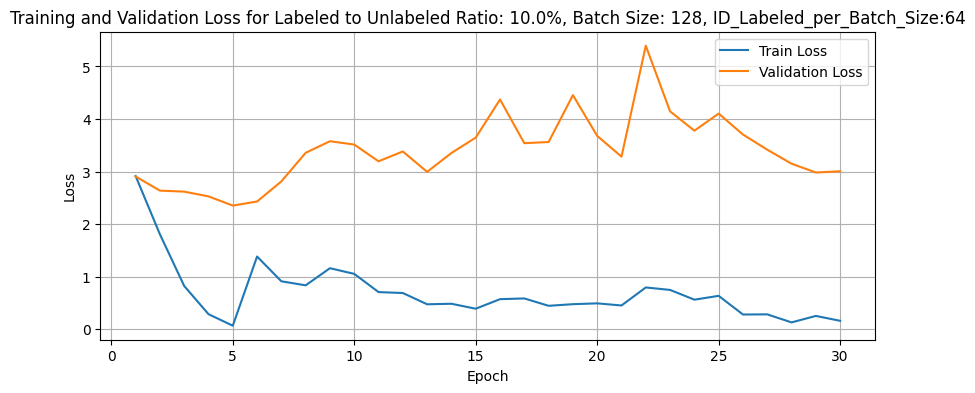

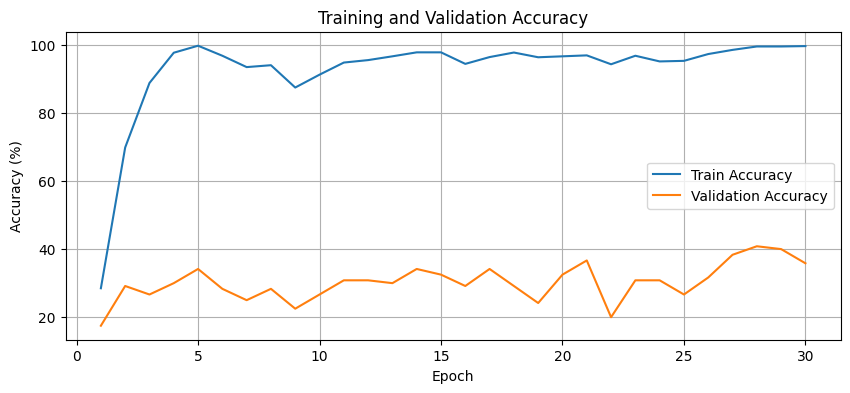

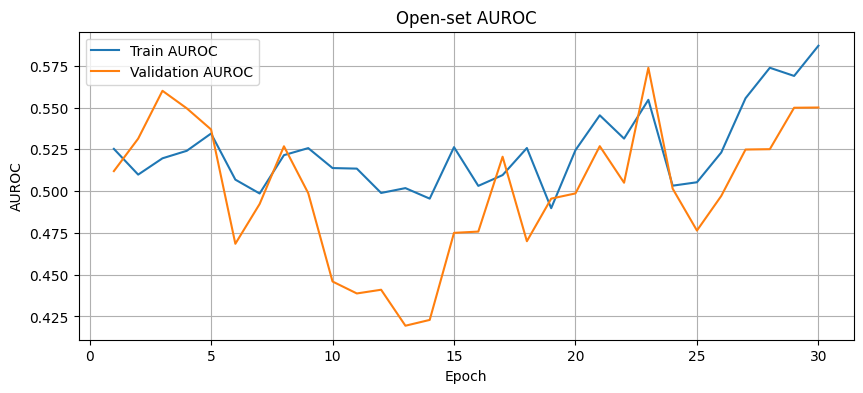

🎉 Training complete.
Detected classes: {'dog': 0, 'pig': 1, 'hen': 2, 'crow': 3, 'frog': 4, 'sheep': 5, 'cow': 6, 'rooster': 7, 'cat': 8, 'insects': 9, 'keyboard_typing': 10, 'clock_tick': 11, 'glass_breaking': 12, 'vacuum_cleaner': 13, 'can_opening': 14, 'mouse_click': 15, 'clock_alarm': 16, 'door_wood_knock': 17, 'door_wood_creaks': 18, 'washing_machine': 19, 'sea_waves': 20, 'crickets': 21, 'water_drops': 22, 'wind': 23, 'crackling_fire': 24, 'rain': 25, 'toilet_flush': 26, 'chirping_birds': 27, 'pouring_water': 28, 'thunderstorm': 29, 'brushing_teeth': 30, 'breathing': 31, 'coughing': 32, 'laughing': 33, 'sneezing': 34, 'snoring': 35, 'footsteps': 36, 'clapping': 37, 'drinking_sipping': 38, 'crying_baby': 39, 'airplane': 40, 'fireworks': 41, 'church_bells': 42, 'chainsaw': 43, 'helicopter': 44, 'engine': 45, 'hand_saw': 46, 'siren': 47, 'car_horn': 48, 'train': 49}


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Epoch [1/30]: 100%|██████████| 15/15 [03:44<00:00, 14.94s/it, loss=3.14]


[Epoch 1] Train Loss: 3.1443, Train Acc: 15.00%, Val Loss: 3.1520, Val Acc: 11.67%, AUROC (Train): 0.5243, AUROC (Val): 0.5156


Epoch [2/30]: 100%|██████████| 15/15 [03:43<00:00, 14.87s/it, loss=1.29]


[Epoch 2] Train Loss: 2.5742, Train Acc: 51.67%, Val Loss: 2.8534, Val Acc: 20.00%, AUROC (Train): 0.5270, AUROC (Val): 0.5059


Epoch [3/30]: 100%|██████████| 15/15 [03:43<00:00, 14.92s/it, loss=0.668]


[Epoch 3] Train Loss: 2.0039, Train Acc: 67.94%, Val Loss: 2.7243, Val Acc: 24.17%, AUROC (Train): 0.5280, AUROC (Val): 0.5314


Epoch [4/30]: 100%|██████████| 15/15 [03:41<00:00, 14.79s/it, loss=0.357]


[Epoch 4] Train Loss: 1.4279, Train Acc: 80.78%, Val Loss: 2.5937, Val Acc: 29.17%, AUROC (Train): 0.5251, AUROC (Val): 0.5203


Epoch [5/30]: 100%|██████████| 15/15 [03:37<00:00, 14.50s/it, loss=0.185]


[Epoch 5] Train Loss: 0.9270, Train Acc: 89.00%, Val Loss: 2.5990, Val Acc: 27.50%, AUROC (Train): 0.5290, AUROC (Val): 0.5458


Epoch [6/30]: 100%|██████████| 15/15 [03:38<00:00, 14.58s/it, loss=0.34] 


[Epoch 6] Train Loss: 2.0427, Train Acc: 88.44%, Val Loss: 3.0884, Val Acc: 19.17%, AUROC (Train): 0.5158, AUROC (Val): 0.5435


Epoch [7/30]: 100%|██████████| 15/15 [03:43<00:00, 14.91s/it, loss=0.22] 


[Epoch 7] Train Loss: 1.5370, Train Acc: 93.11%, Val Loss: 2.5727, Val Acc: 30.83%, AUROC (Train): 0.4858, AUROC (Val): 0.4540
tau_id: -4.4317142248153685
tau_ood: -3.592474806308746
margin_ood: -3.2567790389060978
✅ Saved best model.


Epoch [8/30]: 100%|██████████| 15/15 [03:43<00:00, 14.88s/it, loss=0.163]


[Epoch 8] Train Loss: 1.3053, Train Acc: 96.83%, Val Loss: 2.6010, Val Acc: 32.50%, AUROC (Train): 0.4750, AUROC (Val): 0.4579
tau_id: -4.4317142248153685
tau_ood: -3.592474806308746
margin_ood: -3.2567790389060978
✅ Saved best model.


Epoch [9/30]: 100%|██████████| 15/15 [03:48<00:00, 15.20s/it, loss=0.132] 


[Epoch 9] Train Loss: 1.1857, Train Acc: 98.39%, Val Loss: 2.6808, Val Acc: 34.17%, AUROC (Train): 0.4723, AUROC (Val): 0.4422
tau_id: -4.4317142248153685
tau_ood: -3.592474806308746
margin_ood: -3.2567790389060978
✅ Saved best model.


Epoch [10/30]: 100%|██████████| 15/15 [03:43<00:00, 14.91s/it, loss=0.102] 


[Epoch 10] Train Loss: 1.0213, Train Acc: 99.61%, Val Loss: 2.7188, Val Acc: 35.00%, AUROC (Train): 0.4864, AUROC (Val): 0.4354
tau_id: -4.4317142248153685
tau_ood: -3.592474806308746
margin_ood: -3.2567790389060978
✅ Saved best model.


Epoch [11/30]: 100%|██████████| 15/15 [03:44<00:00, 14.93s/it, loss=0.0901]


[Epoch 11] Train Loss: 0.9911, Train Acc: 99.56%, Val Loss: 2.7870, Val Acc: 30.00%, AUROC (Train): 0.4666, AUROC (Val): 0.4271


Epoch [12/30]: 100%|██████████| 15/15 [03:44<00:00, 15.00s/it, loss=0.0773]


[Epoch 12] Train Loss: 0.9275, Train Acc: 99.83%, Val Loss: 2.7297, Val Acc: 34.17%, AUROC (Train): 0.4828, AUROC (Val): 0.4245


Epoch [13/30]: 100%|██████████| 15/15 [03:43<00:00, 14.92s/it, loss=0.0698]


[Epoch 13] Train Loss: 0.9071, Train Acc: 100.00%, Val Loss: 2.6636, Val Acc: 41.67%, AUROC (Train): 0.5020, AUROC (Val): 0.4534
tau_id: -4.4317142248153685
tau_ood: -3.592474806308746
margin_ood: -3.2567790389060978
✅ Saved best model.


Epoch [14/30]: 100%|██████████| 15/15 [03:44<00:00, 14.95s/it, loss=0.069] 


[Epoch 14] Train Loss: 0.9654, Train Acc: 100.00%, Val Loss: 3.2184, Val Acc: 30.83%, AUROC (Train): 0.4981, AUROC (Val): 0.4148


Epoch [15/30]: 100%|██████████| 15/15 [03:44<00:00, 14.96s/it, loss=0.0604]


[Epoch 15] Train Loss: 0.9064, Train Acc: 100.00%, Val Loss: 3.2222, Val Acc: 31.67%, AUROC (Train): 0.4823, AUROC (Val): 0.4022


Epoch [16/30]: 100%|██████████| 15/15 [03:42<00:00, 14.87s/it, loss=0.0526]


[Epoch 16] Train Loss: 0.8415, Train Acc: 99.94%, Val Loss: 2.6495, Val Acc: 36.67%, AUROC (Train): 0.4983, AUROC (Val): 0.3988


Epoch [17/30]: 100%|██████████| 15/15 [03:44<00:00, 14.99s/it, loss=0.0497]


[Epoch 17] Train Loss: 0.8453, Train Acc: 99.94%, Val Loss: 2.6919, Val Acc: 38.33%, AUROC (Train): 0.4862, AUROC (Val): 0.3913


Epoch [18/30]: 100%|██████████| 15/15 [03:44<00:00, 14.94s/it, loss=0.0479]


[Epoch 18] Train Loss: 0.8631, Train Acc: 100.00%, Val Loss: 2.8125, Val Acc: 33.33%, AUROC (Train): 0.4839, AUROC (Val): 0.3956


Epoch [19/30]: 100%|██████████| 15/15 [03:41<00:00, 14.74s/it, loss=0.042] 


[Epoch 19] Train Loss: 0.7983, Train Acc: 100.00%, Val Loss: 2.8942, Val Acc: 36.67%, AUROC (Train): 0.4620, AUROC (Val): 0.4083


Epoch [20/30]: 100%|██████████| 15/15 [03:41<00:00, 14.78s/it, loss=0.0401]


[Epoch 20] Train Loss: 0.8027, Train Acc: 99.94%, Val Loss: 2.6167, Val Acc: 40.83%, AUROC (Train): 0.4565, AUROC (Val): 0.3596


Epoch [21/30]: 100%|██████████| 15/15 [03:38<00:00, 14.57s/it, loss=0.0382]


[Epoch 21] Train Loss: 0.8017, Train Acc: 100.00%, Val Loss: 2.7159, Val Acc: 37.50%, AUROC (Train): 0.4823, AUROC (Val): 0.3885


Epoch [22/30]: 100%|██████████| 15/15 [03:42<00:00, 14.83s/it, loss=0.0357]


[Epoch 22] Train Loss: 0.7861, Train Acc: 100.00%, Val Loss: 2.7131, Val Acc: 40.00%, AUROC (Train): 0.4953, AUROC (Val): 0.4044


Epoch [23/30]: 100%|██████████| 15/15 [03:41<00:00, 14.77s/it, loss=0.0331]


[Epoch 23] Train Loss: 0.7621, Train Acc: 100.00%, Val Loss: 2.6483, Val Acc: 42.50%, AUROC (Train): 0.4883, AUROC (Val): 0.3999
tau_id: -4.4317142248153685
tau_ood: -3.592474806308746
margin_ood: -3.2567790389060978
✅ Saved best model.


Epoch [24/30]: 100%|██████████| 15/15 [03:41<00:00, 14.75s/it, loss=0.0321]


[Epoch 24] Train Loss: 0.7716, Train Acc: 100.00%, Val Loss: 2.8134, Val Acc: 40.00%, AUROC (Train): 0.4550, AUROC (Val): 0.3481


Epoch [25/30]: 100%|██████████| 15/15 [03:41<00:00, 14.77s/it, loss=0.0303]


[Epoch 25] Train Loss: 0.7584, Train Acc: 100.00%, Val Loss: 2.8517, Val Acc: 35.83%, AUROC (Train): 0.4900, AUROC (Val): 0.3915


Epoch [26/30]: 100%|██████████| 15/15 [03:44<00:00, 14.99s/it, loss=0.0284]


[Epoch 26] Train Loss: 0.7377, Train Acc: 99.94%, Val Loss: 2.6211, Val Acc: 44.17%, AUROC (Train): 0.4893, AUROC (Val): 0.3978
tau_id: -4.4317142248153685
tau_ood: -3.592474806308746
margin_ood: -3.2567790389060978
✅ Saved best model.


Epoch [27/30]: 100%|██████████| 15/15 [03:42<00:00, 14.85s/it, loss=0.0275]


[Epoch 27] Train Loss: 0.7414, Train Acc: 100.00%, Val Loss: 2.6254, Val Acc: 40.00%, AUROC (Train): 0.4755, AUROC (Val): 0.3772


Epoch [28/30]: 100%|██████████| 15/15 [03:46<00:00, 15.11s/it, loss=0.0266]


[Epoch 28] Train Loss: 0.7438, Train Acc: 100.00%, Val Loss: 2.8598, Val Acc: 35.00%, AUROC (Train): 0.4655, AUROC (Val): 0.3842


Epoch [29/30]: 100%|██████████| 15/15 [03:42<00:00, 14.85s/it, loss=0.0245]


[Epoch 29] Train Loss: 0.7101, Train Acc: 99.94%, Val Loss: 2.6743, Val Acc: 40.00%, AUROC (Train): 0.4982, AUROC (Val): 0.3886


Epoch [30/30]: 100%|██████████| 15/15 [03:42<00:00, 14.85s/it, loss=0.0235]


[Epoch 30] Train Loss: 0.7055, Train Acc: 100.00%, Val Loss: 2.7684, Val Acc: 39.17%, AUROC (Train): 0.4937, AUROC (Val): 0.3770


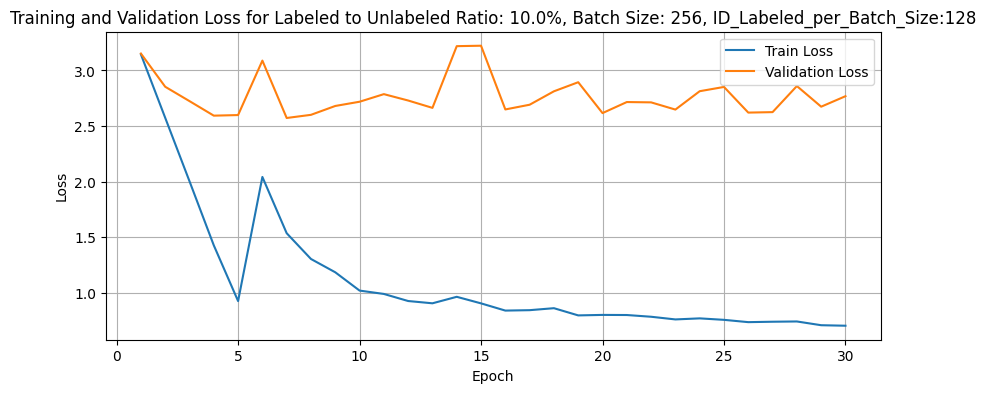

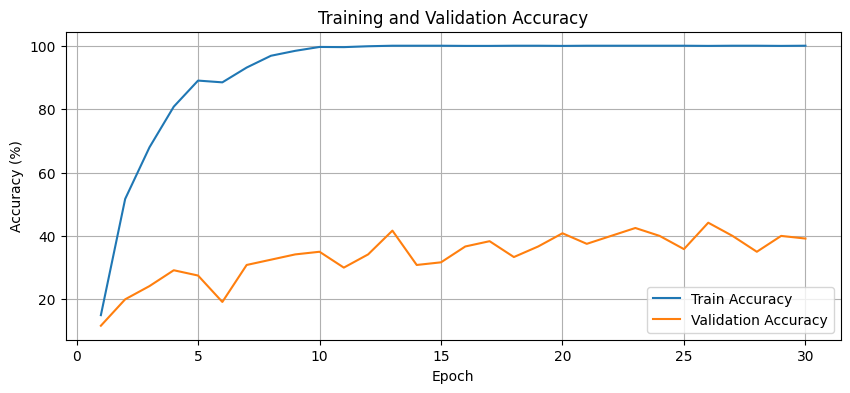

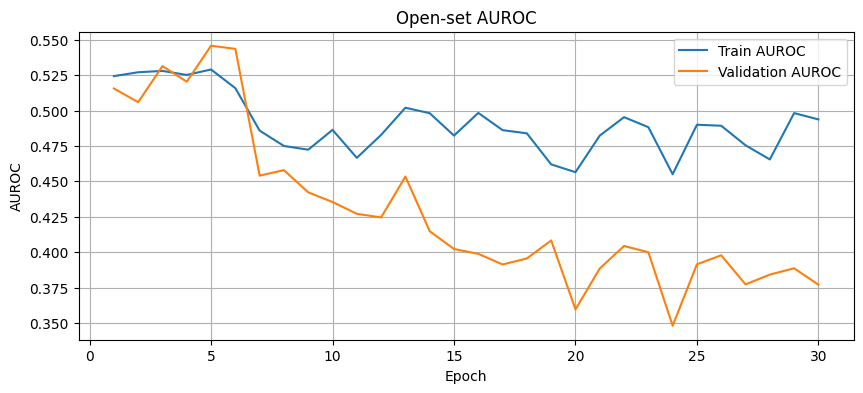

🎉 Training complete.


In [2]:


import os
import random
from collections import defaultdict
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18
from tqdm import tqdm
import librosa

### Utility Functions
def set_seed(seed=42):
    """Set random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def stratified_split(data, val_ratio=0.1):
    """Perform stratified split of data into training and validation sets."""
    paths = [item[0] for item in data]
    labels = [item[1] for item in data]
    sss = StratifiedShuffleSplit(n_splits=1, test_size=val_ratio, random_state=42)
    train_idx, val_idx = next(sss.split(paths, labels))
    train_data = [data[i] for i in train_idx]
    val_data = [data[i] for i in val_idx]
    return train_data, val_data

def create_unlabeled_data(data, unlabeled_ratio):
    """Mark a fraction of data as unlabeled by setting labels to -1."""
    data_by_class = defaultdict(list)
    for idx, (path, label) in enumerate(data):
        data_by_class[label].append(idx)
    new_data = data.copy()
    for label, indices in data_by_class.items():
        n = len(indices)
        n_unlabeled = int(np.round(unlabeled_ratio * n))
        unlabeled_indices = random.sample(indices, n_unlabeled)
        for idx in unlabeled_indices:
            new_data[idx] = (new_data[idx][0], -1)
    return new_data

def build_unlabeled_eval_list(train_id_data, ood_data, val_id_data, ood_pool_size=None):
    """Build evaluation lists for open-set detection."""
    train_unlabeled_eval = [(file, 1) for file, _ in train_id_data] + [(file, 0) for file, _ in ood_data]
    val_unlabeled_eval = [(file, 1) for file, _ in val_id_data]
    if ood_pool_size is None:
        ood_pool_size = len(val_id_data)
    val_ood_samples = random.sample([(file, 0) for file, _ in ood_data], min(len(ood_data), ood_pool_size))
    val_unlabeled_eval.extend(val_ood_samples)
    return train_unlabeled_eval, val_unlabeled_eval

### Data Loading and Preprocessing
def load_esc50_dataset(root_dir):
    """Load ESC-50 dataset from directory structure without a CSV file."""
    data = []
    class_to_idx = {}
    class_names = []

    # Walk through subdirectories (e.g., esc_50/animals/cow/)
    for root, dirs, files in os.walk(root_dir):
        for file_name in files:
            if file_name.endswith('.wav'):
                class_name = os.path.basename(os.path.dirname(os.path.join(root, file_name)))
                if class_name not in class_to_idx:
                    class_to_idx[class_name] = len(class_to_idx)
                    class_names.append(class_name)
                label = class_to_idx[class_name]
                file_path = os.path.join(root, file_name)
                data.append((file_path, label))

    print("Detected classes:", class_to_idx)

    # Select OOD classes arbitrarily for testing (e.g., last 1/3rd)
    num_total_classes = len(class_to_idx)
    ood_class_names = class_names[int(num_total_classes * 3 / 5):]
    id_data = [(file, label) for file, label in data if class_names[label] not in ood_class_names]
    ood_data = [(file, -1) for file, label in data if class_names[label] in ood_class_names]

    # Remap ID labels
    id_labels = sorted(set(label for _, label in id_data))
    id_label_to_idx = {label: idx for idx, label in enumerate(id_labels)}
    id_data = [(file, id_label_to_idx[label]) for file, label in id_data]

    num_classes = len(id_label_to_idx)
    return id_data, ood_data, num_classes


def compute_mel_spec(signal, sr=44100, n_mels=128, hop_length=512, n_fft=2048):
    """Compute Mel spectrogram from audio signal and resize to 128x128."""
    mel = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=n_mels, hop_length=hop_length, n_fft=n_fft)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    tensor = torch.tensor(mel_db).float()
    tensor = F.interpolate(tensor.unsqueeze(0).unsqueeze(0), size=(128, 128), mode='bilinear', align_corners=False)
    return tensor.squeeze(0).squeeze(0)

def audio_weak_transform(signal, sr):
    """Apply weak augmentation to audio signal."""
    if random.random() < 0.5:
        noise = np.random.normal(0, 1, len(signal))
        signal = signal + 0.02 * noise
    else:
        signal = librosa.effects.pitch_shift(signal, sr=sr, n_steps=random.uniform(-2, 2))
    return signal

def audio_strong_transform(signal, sr):
    """Apply strong augmentation to audio signal."""
    signal = signal + 0.05 * np.random.normal(0, 1, len(signal))
    signal = librosa.effects.pitch_shift(signal, sr=sr, n_steps=random.uniform(-5, 5))
    return signal

def spec_augment(mel_tensor, time_mask=25, freq_mask=12):
    """Apply SpecAugment to spectrogram (time and frequency masking)."""
    mel_aug = mel_tensor.clone()
    if mel_aug.shape[1] > time_mask:
        t0 = random.randint(0, mel_aug.shape[1] - time_mask)
        mel_aug[:, t0:t0 + time_mask] = 0
    if mel_aug.shape[0] > freq_mask:
        f0 = random.randint(0, mel_aug.shape[0] - freq_mask)
        mel_aug[f0:f0 + freq_mask, :] = 0
    return mel_aug

### Dataset Class
class ESC50Dataset(Dataset):
    def __init__(self, file_list, return_two_views=False, weak_transform=None, strong_transform=None, transform=None):
        self.file_list = file_list
        self.return_two_views = return_two_views
        self.weak_transform = weak_transform
        self.strong_transform = strong_transform
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        file_path, label = self.file_list[index]
        signal, sr = librosa.load(file_path, sr=44100)
        
        if self.return_two_views:
            # Unlabeled data: return weak and strong views
            sig_weak = self.weak_transform(signal, sr) if self.weak_transform else signal
            spec_weak = compute_mel_spec(sig_weak)
            sig_strong = self.strong_transform(signal, sr) if self.strong_transform else signal
            spec_strong = compute_mel_spec(sig_strong)
            spec_strong = spec_augment(spec_strong)
            return spec_weak.unsqueeze(0), spec_strong.unsqueeze(0), label
        else:
            # Labeled or validation data: return single view
            sig = self.transform(signal, sr) if self.transform else signal
            spec = compute_mel_spec(sig)
            return spec.unsqueeze(0), label

### Model Definition
class SeFOSS(nn.Module):
    def __init__(self, num_classes, proj_dim=128, dropout_rate = 0.25):
        super(SeFOSS, self).__init__()
        backbone = resnet18(pretrained=False)
        # Modify conv1 to accept single-channel input
        backbone.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.feature_extractor = nn.Sequential(*(list(backbone.children())[:-1]))
        self.feature_dim = backbone.fc.in_features
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(self.feature_dim, num_classes)
        self.projection = nn.Linear(self.feature_dim, proj_dim)

    def forward_backbone(self, x):
        features = self.feature_extractor(x)
        return features.view(x.size(0), -1)

    def forward(self, x):
        features = self.forward_backbone(x)
        logits = self.classifier(features)
        return logits

    def forward_features(self, x):
        return self.forward_backbone(x)

    def forward_projection(self, features):
        return self.projection(features)

### Loss Functions
def free_energy(logits):
    """Compute free energy for OOD detection."""
    return -torch.logsumexp(logits, dim=1)

def cosine_similarity_loss(f1, f2):
    """Compute cosine similarity loss for self-supervision."""
    f1_norm = F.normalize(f1, p=2, dim=1)
    f2_norm = F.normalize(f2, p=2, dim=1)
    return -(f1_norm * f2_norm).sum(dim=1).mean()

### Main Function
def main(labeled_ratio_given=0.1, total_epochs=30, batchSize=64, ID_Labeled_Size=16):
    set_seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    data_root = "/kaggle/input/esc-50/esc_50"  # Update path accordingly
    id_data, ood_data, num_classes = load_esc50_dataset(data_root)

    train_id_data, val_id_data = stratified_split(id_data, val_ratio=0.1)
    train_id_data = create_unlabeled_data(train_id_data, unlabeled_ratio=1 - labeled_ratio_given)

    train_labeled_data = [x for x in train_id_data if x[1] != -1]
    train_unlabeled_data = train_id_data + ood_data

    train_unlabeled_eval_list, val_unlabeled_eval_list = build_unlabeled_eval_list(train_id_data, ood_data, val_id_data)

    # Datasets
    labeled_dataset = ESC50Dataset(train_labeled_data, transform=audio_weak_transform)
    unlabeled_dataset = ESC50Dataset(train_unlabeled_data, return_two_views=True,
                                     weak_transform=audio_weak_transform, strong_transform=audio_strong_transform)
    val_dataset = ESC50Dataset(val_id_data, transform=None)
    train_unlabeled_eval_ds = ESC50Dataset(train_unlabeled_eval_list, transform=None)
    val_unlabeled_eval_ds = ESC50Dataset(val_unlabeled_eval_list, transform=None)

    # DataLoaders
    labeled_loader = DataLoader(labeled_dataset, batch_size=ID_Labeled_Size, shuffle=True, num_workers=4)
    unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batchSize - ID_Labeled_Size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batchSize, shuffle=False, num_workers=4)
    train_unlabeled_eval_loader = DataLoader(train_unlabeled_eval_ds, batch_size=batchSize, shuffle=False, num_workers=4)
    val_unlabeled_eval_loader = DataLoader(val_unlabeled_eval_ds, batch_size=batchSize, shuffle=False, num_workers=4)

    # Model & Optim
    model = SeFOSS(num_classes=num_classes, proj_dim=128).to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.004, momentum=0.9, weight_decay=5e-3, nesterov=True)
    # scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_epochs) 
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_epochs*2) 

    # Tracking
    train_loss_list, val_loss_list = [], []
    train_acc_list, val_acc_list = [], []
    train_auroc_list, val_auroc_list = [], []

    best_val_acc = 0.0
    global_step = 0

    # Threshold Hyperparameters
    zeta_id, zeta_ood, xi_ood = 0.2, 1.3, 1.9
    tau_id, tau_ood, margin_ood = 0.0, 0.0, 0.0
    pretrain_epochs = 5
    lambda_ss, lambda_p, lambda_e = 0.1, 0.5, 0.1

    for epoch in range(total_epochs):
        if epoch == pretrain_epochs:
            model.eval()
            energy_scores = []
            with torch.no_grad():
                for spec, _ in labeled_loader:
                    spec = spec.to(device)
                    logits = model(spec)
                    energy_scores.extend(free_energy(logits).cpu().numpy())

            S_m = np.median(energy_scores)
            S_iqr = np.percentile(energy_scores, 75) - np.percentile(energy_scores, 25)
            tau_id = S_m - S_iqr * zeta_id
            tau_ood = S_m + S_iqr * zeta_ood
            margin_ood = S_m + S_iqr * xi_ood

        model.train()
        running_loss, correct, total = 0.0, 0, 0
        labeled_iter = iter(labeled_loader)
        unlabeled_iter = iter(unlabeled_loader)

        pbar = tqdm(range(len(unlabeled_loader)), desc=f"Epoch [{epoch+1}/{total_epochs}]")
        for _ in pbar:
            try:
                spec_l, target_l = next(labeled_iter)
            except StopIteration:
                labeled_iter = iter(labeled_loader)
                spec_l, target_l = next(labeled_iter)

            try:
                spec_w, spec_s, _ = next(unlabeled_iter)
            except StopIteration:
                unlabeled_iter = iter(unlabeled_loader)
                spec_w, spec_s, _ = next(unlabeled_iter)

            spec_l, target_l = spec_l.to(device), target_l.to(device)
            spec_w, spec_s = spec_w.to(device), spec_s.to(device)

            optimizer.zero_grad()
            logits_l = model(spec_l)
            loss_sup = F.cross_entropy(logits_l, target_l)
            preds = torch.argmax(logits_l, dim=1)
            correct += (preds == target_l).sum().item()
            total += target_l.size(0)

            # Self-supervised loss
            feat_w = model.forward_features(spec_w)
            feat_s = model.forward_features(spec_s)
            proj_w = model.forward_projection(feat_w)
            proj_s = model.forward_projection(feat_s)
            loss_ss = cosine_similarity_loss(proj_s, proj_w.detach())

            # Pseudo-labeling
            logits_w = model(spec_w)
            logits_s = model(spec_s)
            fe = free_energy(logits_w)
            if epoch < pretrain_epochs:
                cur_tau_id = 0.5
                cur_tau_ood = 1.0
                cur_margin_ood = 1.5
            else:
                cur_tau_id = tau_id
                cur_tau_ood = tau_ood
                cur_margin_ood = margin_ood

            pseudo_mask = fe < cur_tau_id
            pseudo_labels = torch.argmax(F.softmax(logits_w, dim=1), dim=1)
            loss_pseudo = F.cross_entropy(logits_s[pseudo_mask], pseudo_labels[pseudo_mask]) if pseudo_mask.any() else 0.0

            # Energy regularization
            energy_mask = fe > cur_tau_ood
            diff = (cur_margin_ood - fe[energy_mask]).clamp(min=0)
            loss_energy = diff.mean() if energy_mask.any() else 0.0

            if epoch < pretrain_epochs:
                loss_total = loss_sup + lambda_ss * loss_ss
            else:
                loss_total = loss_sup + lambda_ss * loss_ss + lambda_p * loss_pseudo + lambda_e * loss_energy

            loss_total.backward()
            optimizer.step()

            running_loss += loss_total.item()
            global_step += 1
            pbar.set_postfix(loss=running_loss / (global_step or 1))

        scheduler.step()
        train_acc = (correct / total) * 100
        avg_train_loss = running_loss / len(unlabeled_loader)

        # Validation Accuracy
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for spec, label in val_loader:
                spec, label = spec.to(device), label.to(device)
                logits = model(spec)
                val_loss += F.cross_entropy(logits, label).item()
                pred = torch.argmax(logits, dim=1)
                val_correct += (pred == label).sum().item()
                val_total += label.size(0)

        val_acc = (val_correct / val_total) * 100
        avg_val_loss = val_loss / len(val_loader)

        # Open-set AUROC Evaluation
        def compute_auroc(loader):
            scores, labels = [], []
            with torch.no_grad():
                for spec, label in loader:
                    spec = spec.to(device)
                    logits = model(spec)
                    energy = -free_energy(logits)
                    scores.extend(energy.cpu().numpy())
                    labels.extend(label.numpy())
            return roc_auc_score(labels, scores)

        train_auroc = compute_auroc(train_unlabeled_eval_loader)
        val_auroc = compute_auroc(val_unlabeled_eval_loader)

        print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%, AUROC (Train): {train_auroc:.4f}, AUROC (Val): {val_auroc:.4f}")
        if epoch>pretrain_epochs:
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), f"best_sefoss_esc50_acc_{best_val_acc:.2f}.pth")
                
                print(f"tau_id: {cur_tau_id}")
                print(f"tau_ood: {cur_tau_ood}")
                print(f"margin_ood: {cur_margin_ood}")
                print("✅ Saved best model.")
        else:
            best_val_acc = 0
        train_loss_list.append(avg_train_loss)
        val_loss_list.append(avg_val_loss)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        train_auroc_list.append(train_auroc)
        val_auroc_list.append(val_auroc)
    epochs = range(1, total_epochs + 1)
    
    # Plot Training and Validation Loss.
    plt.figure(figsize=(10, 4))
    plt.plot(epochs, train_loss_list, label="Train Loss")
    plt.plot(epochs, val_loss_list, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Training and Validation Loss for Labeled to Unlabeled Ratio: {labeled_ratio_given*100}%, Batch Size: {batchSize}, ID_Labeled_per_Batch_Size:{ID_Labeled_Size}")
    plt.legend()
    plt.grid(True)
    plt.savefig("loss_plot.png")
    plt.show()
    
    # Plot Training and Validation Accuracy.
    plt.figure(figsize=(10, 4))
    plt.plot(epochs, train_acc_list, label="Train Accuracy")
    plt.plot(epochs, val_acc_list, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.savefig("accuracy_plot.png")
    plt.show()
    
    # Plot AUROC curves.
    plt.figure(figsize=(10, 4))
    plt.plot(epochs, train_auroc_list, label="Train AUROC")
    plt.plot(epochs, val_auroc_list, label="Validation AUROC")
    plt.xlabel("Epoch")
    plt.ylabel("AUROC")
    plt.title("Open-set AUROC")
    plt.legend()
    plt.grid(True)
    plt.savefig("auroc_plot.png")
    plt.show()
    print("🎉 Training complete.")

main(labeled_ratio_given=0.1, batchSize=64, ID_Labeled_Size=32)
main(labeled_ratio_given=0.1, batchSize=128, ID_Labeled_Size=48)
main(labeled_ratio_given=0.1, batchSize=128, ID_Labeled_Size=64)
main(labeled_ratio_given=0.1, batchSize=256, ID_Labeled_Size=128)





Detected classes: {'dog': 0, 'pig': 1, 'hen': 2, 'crow': 3, 'frog': 4, 'sheep': 5, 'cow': 6, 'rooster': 7, 'cat': 8, 'insects': 9, 'keyboard_typing': 10, 'clock_tick': 11, 'glass_breaking': 12, 'vacuum_cleaner': 13, 'can_opening': 14, 'mouse_click': 15, 'clock_alarm': 16, 'door_wood_knock': 17, 'door_wood_creaks': 18, 'washing_machine': 19, 'sea_waves': 20, 'crickets': 21, 'water_drops': 22, 'wind': 23, 'crackling_fire': 24, 'rain': 25, 'toilet_flush': 26, 'chirping_birds': 27, 'pouring_water': 28, 'thunderstorm': 29, 'brushing_teeth': 30, 'breathing': 31, 'coughing': 32, 'laughing': 33, 'sneezing': 34, 'snoring': 35, 'footsteps': 36, 'clapping': 37, 'drinking_sipping': 38, 'crying_baby': 39, 'airplane': 40, 'fireworks': 41, 'church_bells': 42, 'chainsaw': 43, 'helicopter': 44, 'engine': 45, 'hand_saw': 46, 'siren': 47, 'car_horn': 48, 'train': 49}


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Epoch [1/30]: 100%|██████████| 33/33 [03:48<00:00,  6.93s/it, loss=3.6] 


[Epoch 1] Train Loss: 3.5972, Train Acc: 5.05%, Val Loss: 3.9297, Val Acc: 5.00%, AUROC (Train): 0.5131, AUROC (Val): 0.5374


Epoch [2/30]: 100%|██████████| 33/33 [02:55<00:00,  5.32s/it, loss=1.6]  


[Epoch 2] Train Loss: 3.1913, Train Acc: 10.10%, Val Loss: 3.2223, Val Acc: 10.00%, AUROC (Train): 0.5225, AUROC (Val): 0.5123


Epoch [3/30]: 100%|██████████| 33/33 [02:55<00:00,  5.32s/it, loss=0.799]


[Epoch 3] Train Loss: 2.3981, Train Acc: 32.83%, Val Loss: 3.2468, Val Acc: 14.17%, AUROC (Train): 0.5180, AUROC (Val): 0.5217


Epoch [4/30]: 100%|██████████| 33/33 [02:55<00:00,  5.32s/it, loss=0.514]


[Epoch 4] Train Loss: 2.0553, Train Acc: 36.36%, Val Loss: 3.6422, Val Acc: 14.17%, AUROC (Train): 0.5411, AUROC (Val): 0.5511


Epoch [5/30]: 100%|██████████| 33/33 [02:55<00:00,  5.33s/it, loss=0.259] 


[Epoch 5] Train Loss: 1.2964, Train Acc: 64.65%, Val Loss: 3.3948, Val Acc: 15.83%, AUROC (Train): 0.5292, AUROC (Val): 0.5210


Epoch [6/30]: 100%|██████████| 33/33 [02:52<00:00,  5.21s/it, loss=0.473]


[Epoch 6] Train Loss: 2.8396, Train Acc: 58.59%, Val Loss: 4.1985, Val Acc: 10.83%, AUROC (Train): 0.5667, AUROC (Val): 0.5097


Epoch [7/30]: 100%|██████████| 33/33 [02:53<00:00,  5.27s/it, loss=0.309] 


[Epoch 7] Train Loss: 2.1607, Train Acc: 71.21%, Val Loss: 2.8654, Val Acc: 28.33%, AUROC (Train): 0.5915, AUROC (Val): 0.5174
tau_id: -5.569129776954651
tau_ood: -3.9571627497673036
margin_ood: -3.3123759388923646
✅ Saved best model.


Epoch [8/30]: 100%|██████████| 33/33 [02:58<00:00,  5.42s/it, loss=0.216] 


[Epoch 8] Train Loss: 1.7301, Train Acc: 66.16%, Val Loss: 3.2683, Val Acc: 24.17%, AUROC (Train): 0.5936, AUROC (Val): 0.5712


Epoch [9/30]: 100%|██████████| 33/33 [02:55<00:00,  5.31s/it, loss=0.154] 


[Epoch 9] Train Loss: 1.3839, Train Acc: 71.72%, Val Loss: 2.7558, Val Acc: 30.00%, AUROC (Train): 0.5732, AUROC (Val): 0.5030
tau_id: -5.569129776954651
tau_ood: -3.9571627497673036
margin_ood: -3.3123759388923646
✅ Saved best model.


Epoch [10/30]: 100%|██████████| 33/33 [02:52<00:00,  5.24s/it, loss=0.121] 


[Epoch 10] Train Loss: 1.2076, Train Acc: 82.32%, Val Loss: 3.1633, Val Acc: 28.33%, AUROC (Train): 0.5397, AUROC (Val): 0.4901


Epoch [11/30]: 100%|██████████| 33/33 [02:57<00:00,  5.37s/it, loss=0.106] 


[Epoch 11] Train Loss: 1.1706, Train Acc: 79.29%, Val Loss: 3.4417, Val Acc: 28.33%, AUROC (Train): 0.5535, AUROC (Val): 0.5398


Epoch [12/30]: 100%|██████████| 33/33 [02:55<00:00,  5.31s/it, loss=0.0934]


[Epoch 12] Train Loss: 1.1206, Train Acc: 85.35%, Val Loss: 2.9745, Val Acc: 28.33%, AUROC (Train): 0.5954, AUROC (Val): 0.5115


Epoch [13/30]: 100%|██████████| 33/33 [02:53<00:00,  5.26s/it, loss=0.0556]


[Epoch 13] Train Loss: 0.7230, Train Acc: 92.42%, Val Loss: 3.4017, Val Acc: 33.33%, AUROC (Train): 0.5535, AUROC (Val): 0.5175
tau_id: -5.569129776954651
tau_ood: -3.9571627497673036
margin_ood: -3.3123759388923646
✅ Saved best model.


Epoch [14/30]: 100%|██████████| 33/33 [02:59<00:00,  5.45s/it, loss=0.062] 


[Epoch 14] Train Loss: 0.8678, Train Acc: 90.40%, Val Loss: 2.7689, Val Acc: 40.00%, AUROC (Train): 0.5893, AUROC (Val): 0.5460
tau_id: -5.569129776954651
tau_ood: -3.9571627497673036
margin_ood: -3.3123759388923646
✅ Saved best model.


Epoch [15/30]: 100%|██████████| 33/33 [02:54<00:00,  5.29s/it, loss=0.0415]


[Epoch 15] Train Loss: 0.6230, Train Acc: 96.97%, Val Loss: 2.6492, Val Acc: 39.17%, AUROC (Train): 0.6193, AUROC (Val): 0.5627


Epoch [16/30]: 100%|██████████| 33/33 [02:53<00:00,  5.25s/it, loss=0.0266] 


[Epoch 16] Train Loss: 0.4250, Train Acc: 94.95%, Val Loss: 2.8969, Val Acc: 43.33%, AUROC (Train): 0.6424, AUROC (Val): 0.5995
tau_id: -5.569129776954651
tau_ood: -3.9571627497673036
margin_ood: -3.3123759388923646
✅ Saved best model.


Epoch [17/30]: 100%|██████████| 33/33 [02:56<00:00,  5.36s/it, loss=0.0281] 


[Epoch 17] Train Loss: 0.4782, Train Acc: 96.46%, Val Loss: 2.8765, Val Acc: 35.00%, AUROC (Train): 0.6137, AUROC (Val): 0.5094


Epoch [18/30]: 100%|██████████| 33/33 [02:56<00:00,  5.35s/it, loss=0.0242] 


[Epoch 18] Train Loss: 0.4354, Train Acc: 99.49%, Val Loss: 2.7075, Val Acc: 40.83%, AUROC (Train): 0.6258, AUROC (Val): 0.5744


Epoch [19/30]: 100%|██████████| 33/33 [02:54<00:00,  5.27s/it, loss=0.0169] 


[Epoch 19] Train Loss: 0.3218, Train Acc: 98.99%, Val Loss: 2.8365, Val Acc: 44.17%, AUROC (Train): 0.6366, AUROC (Val): 0.5840
tau_id: -5.569129776954651
tau_ood: -3.9571627497673036
margin_ood: -3.3123759388923646
✅ Saved best model.


Epoch [20/30]: 100%|██████████| 33/33 [02:53<00:00,  5.25s/it, loss=0.0204] 


[Epoch 20] Train Loss: 0.4078, Train Acc: 98.48%, Val Loss: 2.8037, Val Acc: 44.17%, AUROC (Train): 0.6146, AUROC (Val): 0.5546


Epoch [21/30]: 100%|██████████| 33/33 [02:59<00:00,  5.44s/it, loss=0.0201] 


[Epoch 21] Train Loss: 0.4225, Train Acc: 98.48%, Val Loss: 2.9727, Val Acc: 41.67%, AUROC (Train): 0.6061, AUROC (Val): 0.5607


Epoch [22/30]: 100%|██████████| 33/33 [02:51<00:00,  5.20s/it, loss=0.0246] 


[Epoch 22] Train Loss: 0.5409, Train Acc: 94.44%, Val Loss: 2.8782, Val Acc: 39.17%, AUROC (Train): 0.6258, AUROC (Val): 0.5568


Epoch [23/30]: 100%|██████████| 33/33 [02:55<00:00,  5.30s/it, loss=0.0133] 


[Epoch 23] Train Loss: 0.3053, Train Acc: 100.00%, Val Loss: 2.8405, Val Acc: 44.17%, AUROC (Train): 0.6268, AUROC (Val): 0.5922


Epoch [24/30]: 100%|██████████| 33/33 [02:56<00:00,  5.36s/it, loss=0.0163] 


[Epoch 24] Train Loss: 0.3902, Train Acc: 94.95%, Val Loss: 2.6045, Val Acc: 41.67%, AUROC (Train): 0.6423, AUROC (Val): 0.5523


Epoch [25/30]: 100%|██████████| 33/33 [02:53<00:00,  5.26s/it, loss=0.0152] 


[Epoch 25] Train Loss: 0.3790, Train Acc: 95.96%, Val Loss: 2.7889, Val Acc: 41.67%, AUROC (Train): 0.6162, AUROC (Val): 0.5524


Epoch [26/30]: 100%|██████████| 33/33 [02:53<00:00,  5.26s/it, loss=0.013]  


[Epoch 26] Train Loss: 0.3390, Train Acc: 98.48%, Val Loss: 2.7378, Val Acc: 42.50%, AUROC (Train): 0.6148, AUROC (Val): 0.5478


Epoch [27/30]: 100%|██████████| 33/33 [02:56<00:00,  5.34s/it, loss=0.00951]


[Epoch 27] Train Loss: 0.2568, Train Acc: 99.49%, Val Loss: 2.7061, Val Acc: 44.17%, AUROC (Train): 0.6213, AUROC (Val): 0.5368


Epoch [28/30]: 100%|██████████| 33/33 [02:57<00:00,  5.37s/it, loss=0.00843]


[Epoch 28] Train Loss: 0.2360, Train Acc: 97.98%, Val Loss: 2.6605, Val Acc: 44.17%, AUROC (Train): 0.6205, AUROC (Val): 0.5614


Epoch [29/30]: 100%|██████████| 33/33 [02:53<00:00,  5.25s/it, loss=0.00971]


[Epoch 29] Train Loss: 0.2816, Train Acc: 96.46%, Val Loss: 2.9735, Val Acc: 40.00%, AUROC (Train): 0.5994, AUROC (Val): 0.5333


Epoch [30/30]: 100%|██████████| 33/33 [02:59<00:00,  5.45s/it, loss=0.00769]


[Epoch 30] Train Loss: 0.2308, Train Acc: 98.99%, Val Loss: 2.8608, Val Acc: 43.33%, AUROC (Train): 0.5881, AUROC (Val): 0.5078


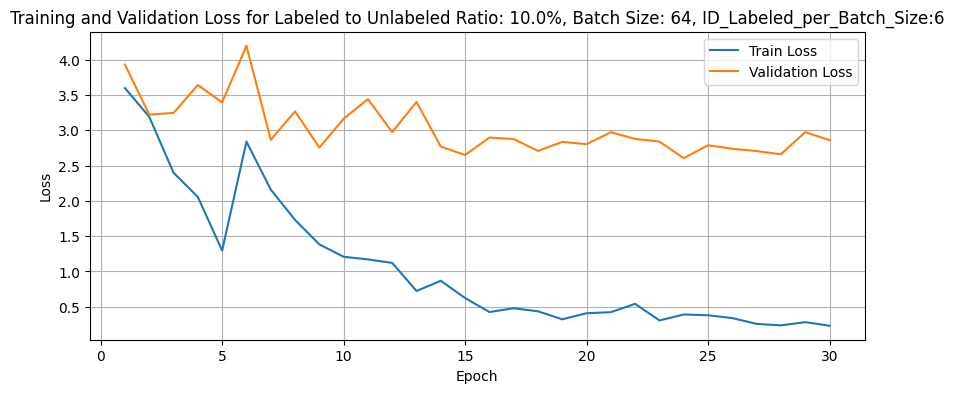

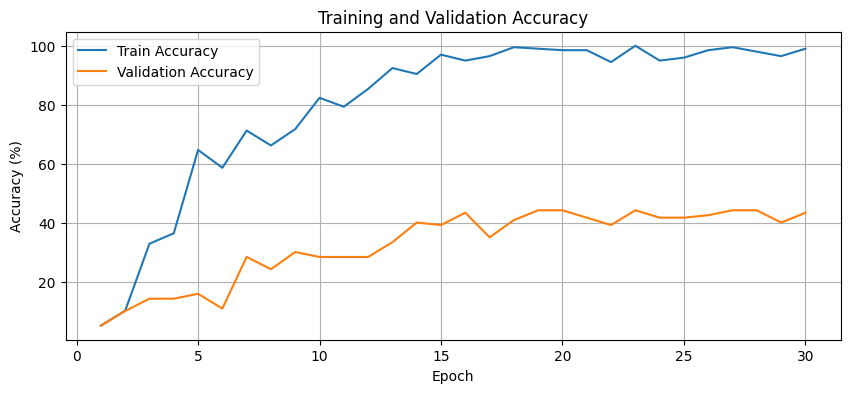

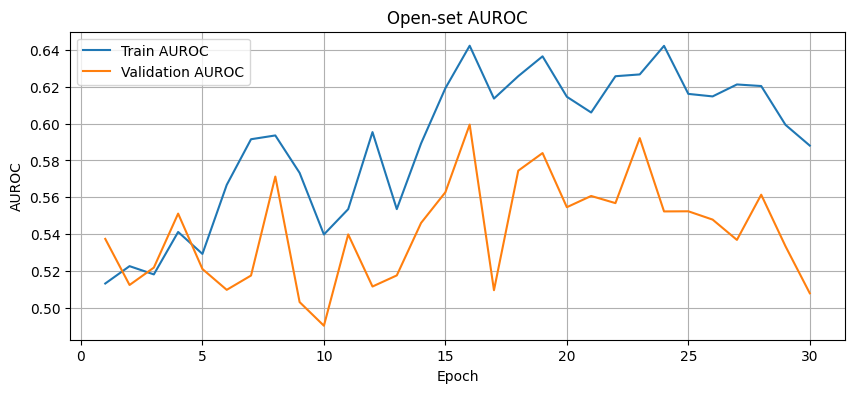

🎉 Training complete.
Detected classes: {'dog': 0, 'pig': 1, 'hen': 2, 'crow': 3, 'frog': 4, 'sheep': 5, 'cow': 6, 'rooster': 7, 'cat': 8, 'insects': 9, 'keyboard_typing': 10, 'clock_tick': 11, 'glass_breaking': 12, 'vacuum_cleaner': 13, 'can_opening': 14, 'mouse_click': 15, 'clock_alarm': 16, 'door_wood_knock': 17, 'door_wood_creaks': 18, 'washing_machine': 19, 'sea_waves': 20, 'crickets': 21, 'water_drops': 22, 'wind': 23, 'crackling_fire': 24, 'rain': 25, 'toilet_flush': 26, 'chirping_birds': 27, 'pouring_water': 28, 'thunderstorm': 29, 'brushing_teeth': 30, 'breathing': 31, 'coughing': 32, 'laughing': 33, 'sneezing': 34, 'snoring': 35, 'footsteps': 36, 'clapping': 37, 'drinking_sipping': 38, 'crying_baby': 39, 'airplane': 40, 'fireworks': 41, 'church_bells': 42, 'chainsaw': 43, 'helicopter': 44, 'engine': 45, 'hand_saw': 46, 'siren': 47, 'car_horn': 48, 'train': 49}


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Epoch [1/30]: 100%|██████████| 30/30 [03:53<00:00,  7.79s/it, loss=2.91]


[Epoch 1] Train Loss: 2.9116, Train Acc: 29.28%, Val Loss: 2.8987, Val Acc: 18.33%, AUROC (Train): 0.5230, AUROC (Val): 0.5324


Epoch [2/30]: 100%|██████████| 30/30 [03:50<00:00,  7.67s/it, loss=0.902]


[Epoch 2] Train Loss: 1.8032, Train Acc: 70.33%, Val Loss: 2.6079, Val Acc: 30.83%, AUROC (Train): 0.5177, AUROC (Val): 0.5417


Epoch [3/30]: 100%|██████████| 30/30 [03:53<00:00,  7.78s/it, loss=0.269]


[Epoch 3] Train Loss: 0.8075, Train Acc: 89.39%, Val Loss: 2.5698, Val Acc: 26.67%, AUROC (Train): 0.5300, AUROC (Val): 0.5567


Epoch [4/30]: 100%|██████████| 30/30 [03:53<00:00,  7.78s/it, loss=0.0681]


[Epoch 4] Train Loss: 0.2725, Train Acc: 97.56%, Val Loss: 2.4957, Val Acc: 31.67%, AUROC (Train): 0.5315, AUROC (Val): 0.5586


Epoch [5/30]: 100%|██████████| 30/30 [03:53<00:00,  7.77s/it, loss=0.0117] 


[Epoch 5] Train Loss: 0.0583, Train Acc: 99.56%, Val Loss: 2.3749, Val Acc: 36.67%, AUROC (Train): 0.5408, AUROC (Val): 0.5588


Epoch [6/30]: 100%|██████████| 30/30 [03:54<00:00,  7.81s/it, loss=0.227]


[Epoch 6] Train Loss: 1.3643, Train Acc: 97.56%, Val Loss: 2.6730, Val Acc: 30.00%, AUROC (Train): 0.4953, AUROC (Val): 0.4927


Epoch [7/30]: 100%|██████████| 30/30 [03:51<00:00,  7.73s/it, loss=0.128] 


[Epoch 7] Train Loss: 0.8932, Train Acc: 97.28%, Val Loss: 3.0339, Val Acc: 26.67%, AUROC (Train): 0.5062, AUROC (Val): 0.5312
tau_id: -5.693381214141846
tau_ood: -3.7887274265289306
margin_ood: -3.026865911483765
✅ Saved best model.


Epoch [8/30]: 100%|██████████| 30/30 [03:52<00:00,  7.75s/it, loss=0.103] 


[Epoch 8] Train Loss: 0.8240, Train Acc: 94.11%, Val Loss: 3.0119, Val Acc: 31.67%, AUROC (Train): 0.5310, AUROC (Val): 0.5178
tau_id: -5.693381214141846
tau_ood: -3.7887274265289306
margin_ood: -3.026865911483765
✅ Saved best model.


Epoch [9/30]: 100%|██████████| 30/30 [03:57<00:00,  7.91s/it, loss=0.097] 


[Epoch 9] Train Loss: 0.8726, Train Acc: 94.00%, Val Loss: 3.2372, Val Acc: 25.83%, AUROC (Train): 0.5342, AUROC (Val): 0.4878


Epoch [10/30]: 100%|██████████| 30/30 [03:57<00:00,  7.93s/it, loss=0.102] 


[Epoch 10] Train Loss: 1.0223, Train Acc: 92.56%, Val Loss: 3.3615, Val Acc: 18.33%, AUROC (Train): 0.4957, AUROC (Val): 0.4910


Epoch [11/30]: 100%|██████████| 30/30 [03:54<00:00,  7.81s/it, loss=0.0652]


[Epoch 11] Train Loss: 0.7172, Train Acc: 91.39%, Val Loss: 4.0734, Val Acc: 19.17%, AUROC (Train): 0.5168, AUROC (Val): 0.4959


Epoch [12/30]: 100%|██████████| 30/30 [03:51<00:00,  7.73s/it, loss=0.0946]


[Epoch 12] Train Loss: 1.1348, Train Acc: 90.17%, Val Loss: 2.9061, Val Acc: 30.83%, AUROC (Train): 0.5124, AUROC (Val): 0.4723


Epoch [13/30]: 100%|██████████| 30/30 [03:38<00:00,  7.29s/it, loss=0.0833]


[Epoch 13] Train Loss: 1.0834, Train Acc: 90.61%, Val Loss: 3.3338, Val Acc: 29.17%, AUROC (Train): 0.5021, AUROC (Val): 0.4195


Epoch [14/30]: 100%|██████████| 30/30 [03:39<00:00,  7.32s/it, loss=0.051]  


[Epoch 14] Train Loss: 0.7139, Train Acc: 97.78%, Val Loss: 3.2406, Val Acc: 35.83%, AUROC (Train): 0.5073, AUROC (Val): 0.3949
tau_id: -5.693381214141846
tau_ood: -3.7887274265289306
margin_ood: -3.026865911483765
✅ Saved best model.


Epoch [15/30]: 100%|██████████| 30/30 [03:37<00:00,  7.24s/it, loss=0.0555] 


[Epoch 15] Train Loss: 0.8319, Train Acc: 96.94%, Val Loss: 4.2550, Val Acc: 22.50%, AUROC (Train): 0.4929, AUROC (Val): 0.4822


Epoch [16/30]: 100%|██████████| 30/30 [03:34<00:00,  7.14s/it, loss=0.0476]


[Epoch 16] Train Loss: 0.7615, Train Acc: 93.00%, Val Loss: 4.0729, Val Acc: 25.83%, AUROC (Train): 0.5451, AUROC (Val): 0.4974


Epoch [17/30]: 100%|██████████| 30/30 [03:49<00:00,  7.64s/it, loss=0.0553]


[Epoch 17] Train Loss: 0.9394, Train Acc: 92.72%, Val Loss: 4.9498, Val Acc: 25.83%, AUROC (Train): 0.5188, AUROC (Val): 0.4715


Epoch [18/30]: 100%|██████████| 30/30 [03:52<00:00,  7.76s/it, loss=0.0362]


[Epoch 18] Train Loss: 0.6511, Train Acc: 95.89%, Val Loss: 4.5299, Val Acc: 24.17%, AUROC (Train): 0.5327, AUROC (Val): 0.4860


Epoch [19/30]: 100%|██████████| 30/30 [03:42<00:00,  7.41s/it, loss=0.0279] 


[Epoch 19] Train Loss: 0.5293, Train Acc: 97.17%, Val Loss: 3.8480, Val Acc: 32.50%, AUROC (Train): 0.5444, AUROC (Val): 0.5027


Epoch [20/30]: 100%|██████████| 30/30 [03:42<00:00,  7.42s/it, loss=0.0257] 


[Epoch 20] Train Loss: 0.5149, Train Acc: 98.72%, Val Loss: 3.2377, Val Acc: 37.50%, AUROC (Train): 0.5593, AUROC (Val): 0.4793
tau_id: -5.693381214141846
tau_ood: -3.7887274265289306
margin_ood: -3.026865911483765
✅ Saved best model.


Epoch [21/30]: 100%|██████████| 30/30 [03:41<00:00,  7.39s/it, loss=0.0197] 


[Epoch 21] Train Loss: 0.4133, Train Acc: 98.39%, Val Loss: 3.4979, Val Acc: 33.33%, AUROC (Train): 0.5542, AUROC (Val): 0.4882


Epoch [22/30]: 100%|██████████| 30/30 [03:40<00:00,  7.35s/it, loss=0.0266] 


[Epoch 22] Train Loss: 0.5844, Train Acc: 98.39%, Val Loss: 3.2649, Val Acc: 36.67%, AUROC (Train): 0.5258, AUROC (Val): 0.4535


Epoch [23/30]: 100%|██████████| 30/30 [03:39<00:00,  7.32s/it, loss=0.0157] 


[Epoch 23] Train Loss: 0.3622, Train Acc: 97.72%, Val Loss: 3.0065, Val Acc: 33.33%, AUROC (Train): 0.5415, AUROC (Val): 0.4458


Epoch [24/30]: 100%|██████████| 30/30 [03:39<00:00,  7.33s/it, loss=0.0248] 


[Epoch 24] Train Loss: 0.5960, Train Acc: 98.00%, Val Loss: 3.4921, Val Acc: 38.33%, AUROC (Train): 0.5449, AUROC (Val): 0.4709
tau_id: -5.693381214141846
tau_ood: -3.7887274265289306
margin_ood: -3.026865911483765
✅ Saved best model.


Epoch [25/30]: 100%|██████████| 30/30 [03:41<00:00,  7.37s/it, loss=0.0145] 


[Epoch 25] Train Loss: 0.3631, Train Acc: 98.28%, Val Loss: 4.4438, Val Acc: 35.00%, AUROC (Train): 0.5064, AUROC (Val): 0.4089


Epoch [26/30]: 100%|██████████| 30/30 [03:40<00:00,  7.36s/it, loss=0.0155] 


[Epoch 26] Train Loss: 0.4027, Train Acc: 97.67%, Val Loss: 4.5422, Val Acc: 30.83%, AUROC (Train): 0.5064, AUROC (Val): 0.4271


Epoch [27/30]: 100%|██████████| 30/30 [03:44<00:00,  7.47s/it, loss=0.0123] 


[Epoch 27] Train Loss: 0.3326, Train Acc: 98.89%, Val Loss: 3.2978, Val Acc: 39.17%, AUROC (Train): 0.5298, AUROC (Val): 0.4459
tau_id: -5.693381214141846
tau_ood: -3.7887274265289306
margin_ood: -3.026865911483765
✅ Saved best model.


Epoch [28/30]: 100%|██████████| 30/30 [03:46<00:00,  7.56s/it, loss=0.0177] 


[Epoch 28] Train Loss: 0.4945, Train Acc: 98.11%, Val Loss: 3.6324, Val Acc: 30.83%, AUROC (Train): 0.5659, AUROC (Val): 0.5065


Epoch [29/30]: 100%|██████████| 30/30 [03:46<00:00,  7.55s/it, loss=0.0165] 


[Epoch 29] Train Loss: 0.4798, Train Acc: 98.50%, Val Loss: 2.9711, Val Acc: 40.83%, AUROC (Train): 0.5712, AUROC (Val): 0.4826
tau_id: -5.693381214141846
tau_ood: -3.7887274265289306
margin_ood: -3.026865911483765
✅ Saved best model.


Epoch [30/30]: 100%|██████████| 30/30 [03:48<00:00,  7.62s/it, loss=0.0151] 


[Epoch 30] Train Loss: 0.4520, Train Acc: 98.33%, Val Loss: 3.5520, Val Acc: 30.83%, AUROC (Train): 0.5405, AUROC (Val): 0.4749


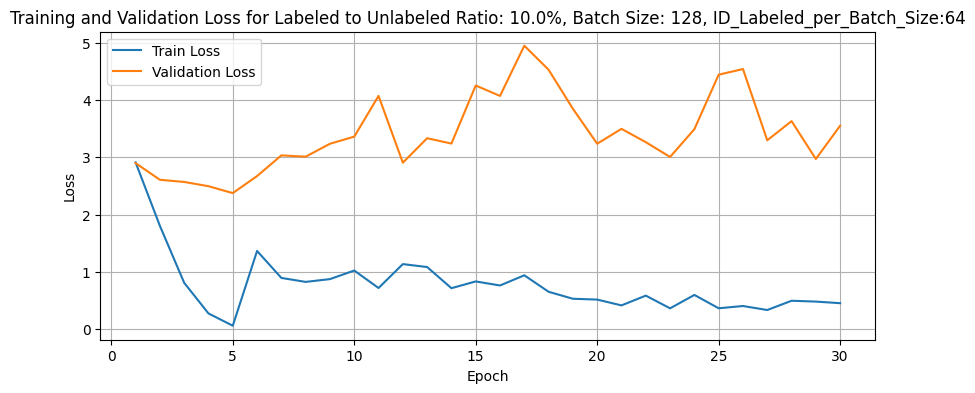

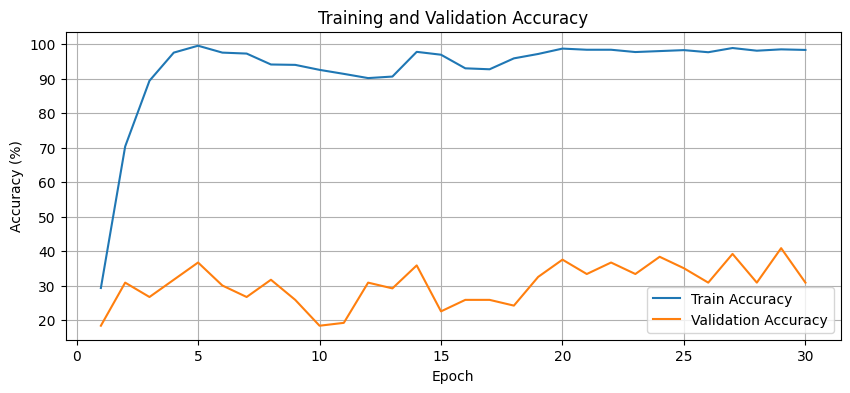

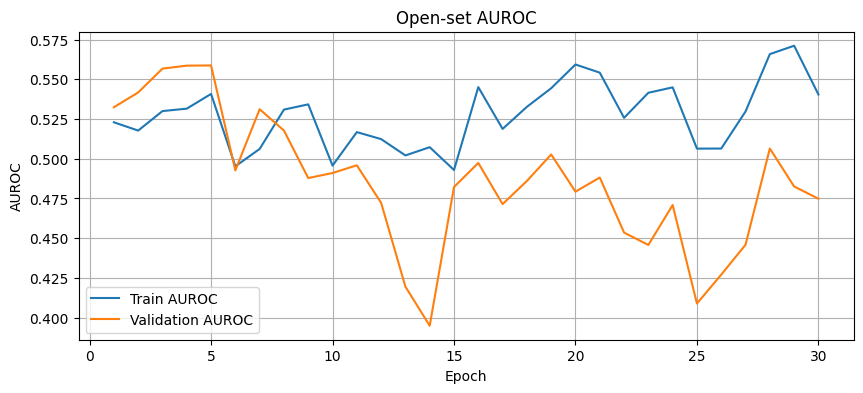

🎉 Training complete.
Detected classes: {'dog': 0, 'pig': 1, 'hen': 2, 'crow': 3, 'frog': 4, 'sheep': 5, 'cow': 6, 'rooster': 7, 'cat': 8, 'insects': 9, 'keyboard_typing': 10, 'clock_tick': 11, 'glass_breaking': 12, 'vacuum_cleaner': 13, 'can_opening': 14, 'mouse_click': 15, 'clock_alarm': 16, 'door_wood_knock': 17, 'door_wood_creaks': 18, 'washing_machine': 19, 'sea_waves': 20, 'crickets': 21, 'water_drops': 22, 'wind': 23, 'crackling_fire': 24, 'rain': 25, 'toilet_flush': 26, 'chirping_birds': 27, 'pouring_water': 28, 'thunderstorm': 29, 'brushing_teeth': 30, 'breathing': 31, 'coughing': 32, 'laughing': 33, 'sneezing': 34, 'snoring': 35, 'footsteps': 36, 'clapping': 37, 'drinking_sipping': 38, 'crying_baby': 39, 'airplane': 40, 'fireworks': 41, 'church_bells': 42, 'chainsaw': 43, 'helicopter': 44, 'engine': 45, 'hand_saw': 46, 'siren': 47, 'car_horn': 48, 'train': 49}


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Epoch [1/30]: 100%|██████████| 30/30 [03:56<00:00,  7.88s/it, loss=3.15]


[Epoch 1] Train Loss: 3.1469, Train Acc: 9.66%, Val Loss: 3.0260, Val Acc: 12.50%, AUROC (Train): 0.5313, AUROC (Val): 0.5561


Epoch [2/30]: 100%|██████████| 30/30 [03:52<00:00,  7.75s/it, loss=1.29] 


[Epoch 2] Train Loss: 2.5786, Train Acc: 30.96%, Val Loss: 2.6425, Val Acc: 23.33%, AUROC (Train): 0.4875, AUROC (Val): 0.4951


Epoch [3/30]: 100%|██████████| 30/30 [03:57<00:00,  7.90s/it, loss=0.65] 


[Epoch 3] Train Loss: 1.9495, Train Acc: 50.50%, Val Loss: 2.3371, Val Acc: 35.83%, AUROC (Train): 0.4831, AUROC (Val): 0.4790


Epoch [5/30]: 100%|██████████| 30/30 [03:59<00:00,  7.98s/it, loss=0.191] 


[Epoch 5] Train Loss: 0.9564, Train Acc: 75.77%, Val Loss: 1.8342, Val Acc: 45.00%, AUROC (Train): 0.4968, AUROC (Val): 0.4383


Epoch [6/30]: 100%|██████████| 30/30 [03:59<00:00,  7.97s/it, loss=0.347]


[Epoch 6] Train Loss: 2.0834, Train Acc: 77.70%, Val Loss: 1.5676, Val Acc: 54.17%, AUROC (Train): 0.5218, AUROC (Val): 0.4420


Epoch [7/30]: 100%|██████████| 30/30 [03:57<00:00,  7.91s/it, loss=0.237] 


[Epoch 7] Train Loss: 1.6619, Train Acc: 82.67%, Val Loss: 1.5703, Val Acc: 50.83%, AUROC (Train): 0.5162, AUROC (Val): 0.4691
tau_id: -5.548580145835876
tau_ood: -3.4671289086341854
margin_ood: -2.63454841375351
✅ Saved best model.


Epoch [8/30]: 100%|██████████| 30/30 [03:58<00:00,  7.95s/it, loss=0.177] 


[Epoch 8] Train Loss: 1.4140, Train Acc: 86.15%, Val Loss: 2.9925, Val Acc: 37.50%, AUROC (Train): 0.5647, AUROC (Val): 0.5463


Epoch [9/30]: 100%|██████████| 30/30 [03:57<00:00,  7.93s/it, loss=0.136] 


[Epoch 9] Train Loss: 1.2244, Train Acc: 89.79%, Val Loss: 1.4995, Val Acc: 56.67%, AUROC (Train): 0.5967, AUROC (Val): 0.5373
tau_id: -5.548580145835876
tau_ood: -3.4671289086341854
margin_ood: -2.63454841375351
✅ Saved best model.


Epoch [10/30]: 100%|██████████| 30/30 [04:01<00:00,  8.04s/it, loss=0.108] 


[Epoch 10] Train Loss: 1.0813, Train Acc: 93.16%, Val Loss: 1.7954, Val Acc: 51.67%, AUROC (Train): 0.5997, AUROC (Val): 0.5372


Epoch [11/30]: 100%|██████████| 30/30 [03:54<00:00,  7.83s/it, loss=0.0904]


[Epoch 11] Train Loss: 0.9942, Train Acc: 92.88%, Val Loss: 1.4238, Val Acc: 56.67%, AUROC (Train): 0.6174, AUROC (Val): 0.5037


Epoch [12/30]: 100%|██████████| 30/30 [03:56<00:00,  7.90s/it, loss=0.079] 


[Epoch 12] Train Loss: 0.9474, Train Acc: 95.09%, Val Loss: 1.3353, Val Acc: 64.17%, AUROC (Train): 0.6338, AUROC (Val): 0.5685
tau_id: -5.548580145835876
tau_ood: -3.4671289086341854
margin_ood: -2.63454841375351
✅ Saved best model.


Epoch [13/30]: 100%|██████████| 30/30 [03:56<00:00,  7.89s/it, loss=0.0705]


[Epoch 13] Train Loss: 0.9170, Train Acc: 95.20%, Val Loss: 1.4727, Val Acc: 60.83%, AUROC (Train): 0.6547, AUROC (Val): 0.5383


Epoch [14/30]: 100%|██████████| 30/30 [03:52<00:00,  7.75s/it, loss=0.058] 


[Epoch 14] Train Loss: 0.8117, Train Acc: 97.35%, Val Loss: 1.4158, Val Acc: 65.00%, AUROC (Train): 0.6458, AUROC (Val): 0.5322
tau_id: -5.548580145835876
tau_ood: -3.4671289086341854
margin_ood: -2.63454841375351
✅ Saved best model.


Epoch [15/30]: 100%|██████████| 30/30 [03:58<00:00,  7.94s/it, loss=0.0518]


[Epoch 15] Train Loss: 0.7763, Train Acc: 97.19%, Val Loss: 1.2619, Val Acc: 62.50%, AUROC (Train): 0.6732, AUROC (Val): 0.5746


Epoch [16/30]: 100%|██████████| 30/30 [03:59<00:00,  7.98s/it, loss=0.0483]


[Epoch 16] Train Loss: 0.7733, Train Acc: 97.52%, Val Loss: 1.3912, Val Acc: 61.67%, AUROC (Train): 0.6490, AUROC (Val): 0.5473


Epoch [17/30]: 100%|██████████| 30/30 [03:56<00:00,  7.89s/it, loss=0.0428]


[Epoch 17] Train Loss: 0.7269, Train Acc: 98.07%, Val Loss: 1.4397, Val Acc: 65.83%, AUROC (Train): 0.6690, AUROC (Val): 0.5501
tau_id: -5.548580145835876
tau_ood: -3.4671289086341854
margin_ood: -2.63454841375351
✅ Saved best model.


Epoch [18/30]: 100%|██████████| 30/30 [03:57<00:00,  7.92s/it, loss=0.039] 


[Epoch 18] Train Loss: 0.7023, Train Acc: 97.85%, Val Loss: 1.2859, Val Acc: 65.00%, AUROC (Train): 0.6669, AUROC (Val): 0.5538


Epoch [19/30]: 100%|██████████| 30/30 [03:58<00:00,  7.95s/it, loss=0.0357]


[Epoch 19] Train Loss: 0.6787, Train Acc: 98.18%, Val Loss: 1.2338, Val Acc: 67.50%, AUROC (Train): 0.6906, AUROC (Val): 0.5552
tau_id: -5.548580145835876
tau_ood: -3.4671289086341854
margin_ood: -2.63454841375351
✅ Saved best model.


Epoch [20/30]: 100%|██████████| 30/30 [03:58<00:00,  7.95s/it, loss=0.0319]


[Epoch 20] Train Loss: 0.6389, Train Acc: 99.01%, Val Loss: 1.3465, Val Acc: 62.50%, AUROC (Train): 0.6927, AUROC (Val): 0.5777


Epoch [21/30]: 100%|██████████| 30/30 [03:56<00:00,  7.90s/it, loss=0.0298]


[Epoch 21] Train Loss: 0.6260, Train Acc: 98.68%, Val Loss: 1.9502, Val Acc: 50.00%, AUROC (Train): 0.5991, AUROC (Val): 0.5277


Epoch [22/30]: 100%|██████████| 30/30 [03:57<00:00,  7.93s/it, loss=0.0289]


[Epoch 22] Train Loss: 0.6365, Train Acc: 99.01%, Val Loss: 1.1521, Val Acc: 63.33%, AUROC (Train): 0.6703, AUROC (Val): 0.5440


Epoch [23/30]: 100%|██████████| 30/30 [03:58<00:00,  7.96s/it, loss=0.0248] 


[Epoch 23] Train Loss: 0.5711, Train Acc: 98.95%, Val Loss: 1.1979, Val Acc: 65.83%, AUROC (Train): 0.7365, AUROC (Val): 0.5703


Epoch [24/30]: 100%|██████████| 30/30 [03:59<00:00,  7.99s/it, loss=0.0251] 


[Epoch 24] Train Loss: 0.6015, Train Acc: 99.28%, Val Loss: 1.2794, Val Acc: 65.00%, AUROC (Train): 0.7281, AUROC (Val): 0.6254


Epoch [25/30]: 100%|██████████| 30/30 [03:58<00:00,  7.95s/it, loss=0.0237] 


[Epoch 25] Train Loss: 0.5917, Train Acc: 99.23%, Val Loss: 1.1613, Val Acc: 68.33%, AUROC (Train): 0.7100, AUROC (Val): 0.5679
tau_id: -5.548580145835876
tau_ood: -3.4671289086341854
margin_ood: -2.63454841375351
✅ Saved best model.


Epoch [26/30]: 100%|██████████| 30/30 [03:57<00:00,  7.91s/it, loss=0.022]  


[Epoch 26] Train Loss: 0.5729, Train Acc: 99.01%, Val Loss: 1.2625, Val Acc: 63.33%, AUROC (Train): 0.7017, AUROC (Val): 0.5779


Epoch [27/30]: 100%|██████████| 30/30 [03:54<00:00,  7.82s/it, loss=0.0203] 


[Epoch 27] Train Loss: 0.5488, Train Acc: 99.28%, Val Loss: 1.3096, Val Acc: 65.00%, AUROC (Train): 0.6885, AUROC (Val): 0.5469


Epoch [28/30]: 100%|██████████| 30/30 [03:59<00:00,  8.00s/it, loss=0.019]  


[Epoch 28] Train Loss: 0.5328, Train Acc: 99.17%, Val Loss: 1.1332, Val Acc: 69.17%, AUROC (Train): 0.7138, AUROC (Val): 0.5734
tau_id: -5.548580145835876
tau_ood: -3.4671289086341854
margin_ood: -2.63454841375351
✅ Saved best model.


Epoch [29/30]: 100%|██████████| 30/30 [04:01<00:00,  8.04s/it, loss=0.0178] 


[Epoch 29] Train Loss: 0.5159, Train Acc: 99.34%, Val Loss: 1.1242, Val Acc: 65.83%, AUROC (Train): 0.7094, AUROC (Val): 0.5601


Epoch [30/30]: 100%|██████████| 30/30 [04:01<00:00,  8.04s/it, loss=0.0172] 


[Epoch 30] Train Loss: 0.5173, Train Acc: 99.39%, Val Loss: 1.2444, Val Acc: 66.67%, AUROC (Train): 0.7219, AUROC (Val): 0.5636


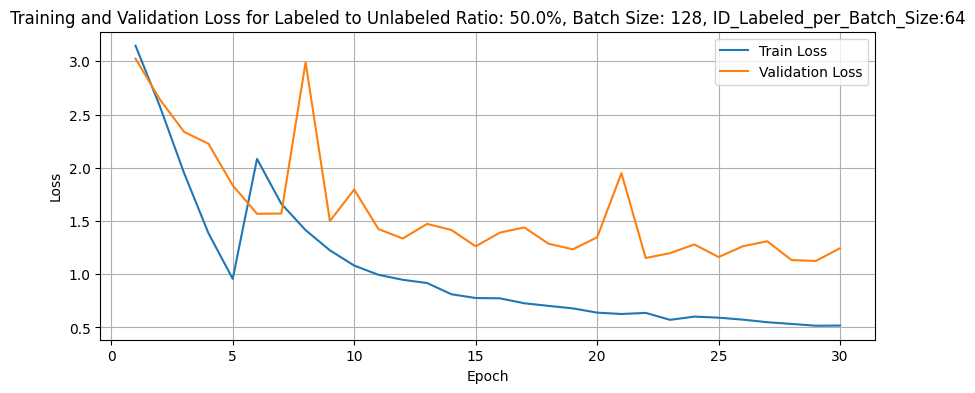

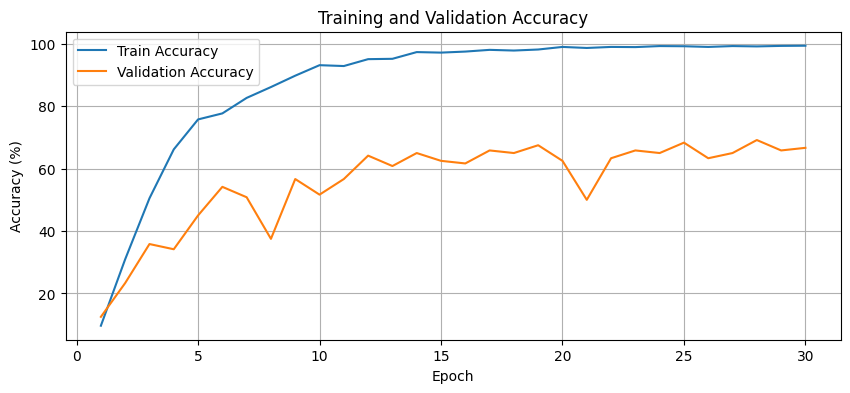

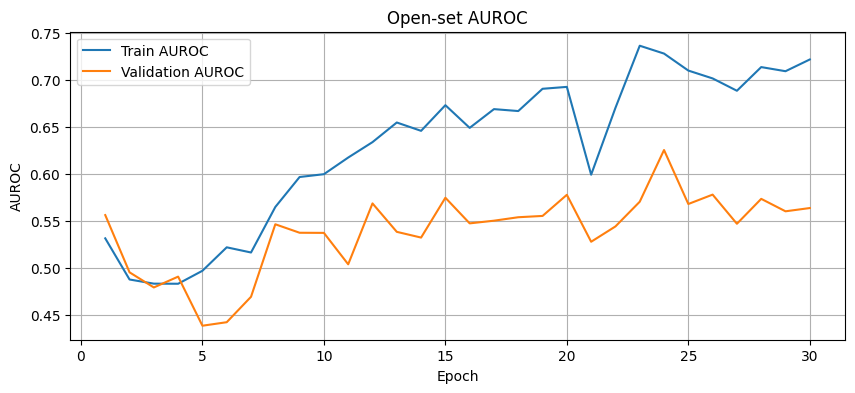

🎉 Training complete.
Detected classes: {'dog': 0, 'pig': 1, 'hen': 2, 'crow': 3, 'frog': 4, 'sheep': 5, 'cow': 6, 'rooster': 7, 'cat': 8, 'insects': 9, 'keyboard_typing': 10, 'clock_tick': 11, 'glass_breaking': 12, 'vacuum_cleaner': 13, 'can_opening': 14, 'mouse_click': 15, 'clock_alarm': 16, 'door_wood_knock': 17, 'door_wood_creaks': 18, 'washing_machine': 19, 'sea_waves': 20, 'crickets': 21, 'water_drops': 22, 'wind': 23, 'crackling_fire': 24, 'rain': 25, 'toilet_flush': 26, 'chirping_birds': 27, 'pouring_water': 28, 'thunderstorm': 29, 'brushing_teeth': 30, 'breathing': 31, 'coughing': 32, 'laughing': 33, 'sneezing': 34, 'snoring': 35, 'footsteps': 36, 'clapping': 37, 'drinking_sipping': 38, 'crying_baby': 39, 'airplane': 40, 'fireworks': 41, 'church_bells': 42, 'chainsaw': 43, 'helicopter': 44, 'engine': 45, 'hand_saw': 46, 'siren': 47, 'car_horn': 48, 'train': 49}


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Epoch [1/30]: 100%|██████████| 15/15 [03:44<00:00, 15.00s/it, loss=3.25]


[Epoch 1] Train Loss: 3.2476, Train Acc: 7.59%, Val Loss: 3.2973, Val Acc: 7.50%, AUROC (Train): 0.5292, AUROC (Val): 0.5566


Epoch [2/30]: 100%|██████████| 15/15 [03:41<00:00, 14.78s/it, loss=1.48]


[Epoch 2] Train Loss: 2.9641, Train Acc: 16.36%, Val Loss: 2.9104, Val Acc: 17.50%, AUROC (Train): 0.5234, AUROC (Val): 0.5628


Epoch [3/30]: 100%|██████████| 15/15 [03:37<00:00, 14.52s/it, loss=0.881]


[Epoch 3] Train Loss: 2.6434, Train Acc: 29.32%, Val Loss: 2.8360, Val Acc: 23.33%, AUROC (Train): 0.5188, AUROC (Val): 0.5620


Epoch [4/30]: 100%|██████████| 15/15 [03:42<00:00, 14.82s/it, loss=0.588]


[Epoch 4] Train Loss: 2.3519, Train Acc: 38.09%, Val Loss: 2.6262, Val Acc: 25.00%, AUROC (Train): 0.4913, AUROC (Val): 0.5281


Epoch [5/30]: 100%|██████████| 15/15 [03:40<00:00, 14.69s/it, loss=0.41] 


[Epoch 5] Train Loss: 2.0512, Train Acc: 48.95%, Val Loss: 2.3876, Val Acc: 37.50%, AUROC (Train): 0.4932, AUROC (Val): 0.5018


Epoch [6/30]: 100%|██████████| 15/15 [03:42<00:00, 14.86s/it, loss=0.529]


[Epoch 6] Train Loss: 3.1727, Train Acc: 46.73%, Val Loss: 2.5918, Val Acc: 20.83%, AUROC (Train): 0.4897, AUROC (Val): 0.4919


Epoch [7/30]: 100%|██████████| 15/15 [03:43<00:00, 14.90s/it, loss=0.405]


[Epoch 7] Train Loss: 2.8339, Train Acc: 53.58%, Val Loss: 2.3055, Val Acc: 32.50%, AUROC (Train): 0.4494, AUROC (Val): 0.4514
tau_id: -4.1928295493125916
tau_ood: -3.2877704203128815
margin_ood: -2.9257467687129974
✅ Saved best model.


Epoch [8/30]: 100%|██████████| 15/15 [03:44<00:00, 14.99s/it, loss=0.311]


[Epoch 8] Train Loss: 2.4852, Train Acc: 61.67%, Val Loss: 2.0868, Val Acc: 35.83%, AUROC (Train): 0.4487, AUROC (Val): 0.4476
tau_id: -4.1928295493125916
tau_ood: -3.2877704203128815
margin_ood: -2.9257467687129974
✅ Saved best model.


Epoch [9/30]: 100%|██████████| 15/15 [03:41<00:00, 14.79s/it, loss=0.244]


[Epoch 9] Train Loss: 2.1974, Train Acc: 70.19%, Val Loss: 1.6315, Val Acc: 56.67%, AUROC (Train): 0.4943, AUROC (Val): 0.4324
tau_id: -4.1928295493125916
tau_ood: -3.2877704203128815
margin_ood: -2.9257467687129974
✅ Saved best model.


Epoch [10/30]: 100%|██████████| 15/15 [03:34<00:00, 14.33s/it, loss=0.196]


[Epoch 10] Train Loss: 1.9582, Train Acc: 75.19%, Val Loss: 1.8440, Val Acc: 50.00%, AUROC (Train): 0.4926, AUROC (Val): 0.4399


Epoch [11/30]: 100%|██████████| 15/15 [03:32<00:00, 14.18s/it, loss=0.166]


[Epoch 11] Train Loss: 1.8294, Train Acc: 81.17%, Val Loss: 1.3652, Val Acc: 60.83%, AUROC (Train): 0.5145, AUROC (Val): 0.4458
tau_id: -4.1928295493125916
tau_ood: -3.2877704203128815
margin_ood: -2.9257467687129974
✅ Saved best model.


Epoch [12/30]: 100%|██████████| 15/15 [03:31<00:00, 14.07s/it, loss=0.136] 


[Epoch 12] Train Loss: 1.6318, Train Acc: 84.32%, Val Loss: 1.4578, Val Acc: 58.33%, AUROC (Train): 0.5010, AUROC (Val): 0.4317


Epoch [13/30]: 100%|██████████| 15/15 [03:28<00:00, 13.88s/it, loss=0.113] 


[Epoch 13] Train Loss: 1.4672, Train Acc: 87.90%, Val Loss: 2.7306, Val Acc: 36.67%, AUROC (Train): 0.5142, AUROC (Val): 0.4693


Epoch [14/30]: 100%|██████████| 15/15 [03:29<00:00, 13.95s/it, loss=0.097] 


[Epoch 14] Train Loss: 1.3585, Train Acc: 89.63%, Val Loss: 1.5878, Val Acc: 54.17%, AUROC (Train): 0.5207, AUROC (Val): 0.4564


Epoch [15/30]: 100%|██████████| 15/15 [03:31<00:00, 14.09s/it, loss=0.0821]


[Epoch 15] Train Loss: 1.2322, Train Acc: 91.11%, Val Loss: 4.6127, Val Acc: 15.83%, AUROC (Train): 0.5350, AUROC (Val): 0.5265


Epoch [16/30]: 100%|██████████| 15/15 [03:31<00:00, 14.10s/it, loss=0.0751]


[Epoch 16] Train Loss: 1.2018, Train Acc: 91.48%, Val Loss: 1.9114, Val Acc: 43.33%, AUROC (Train): 0.5322, AUROC (Val): 0.4762


Epoch [17/30]: 100%|██████████| 15/15 [03:33<00:00, 14.26s/it, loss=0.0682]


[Epoch 17] Train Loss: 1.1588, Train Acc: 92.22%, Val Loss: 1.2575, Val Acc: 65.00%, AUROC (Train): 0.5864, AUROC (Val): 0.5140
tau_id: -4.1928295493125916
tau_ood: -3.2877704203128815
margin_ood: -2.9257467687129974
✅ Saved best model.


Epoch [18/30]: 100%|██████████| 15/15 [03:29<00:00, 13.98s/it, loss=0.0582]


[Epoch 18] Train Loss: 1.0470, Train Acc: 95.00%, Val Loss: 4.4568, Val Acc: 15.00%, AUROC (Train): 0.5278, AUROC (Val): 0.5009


Epoch [19/30]: 100%|██████████| 15/15 [03:32<00:00, 14.14s/it, loss=0.0536]


[Epoch 19] Train Loss: 1.0175, Train Acc: 95.49%, Val Loss: 1.7486, Val Acc: 54.17%, AUROC (Train): 0.5296, AUROC (Val): 0.4627


Epoch [20/30]: 100%|██████████| 15/15 [03:35<00:00, 14.37s/it, loss=0.048] 


[Epoch 20] Train Loss: 0.9599, Train Acc: 95.37%, Val Loss: 1.2013, Val Acc: 66.67%, AUROC (Train): 0.6086, AUROC (Val): 0.5033
tau_id: -4.1928295493125916
tau_ood: -3.2877704203128815
margin_ood: -2.9257467687129974
✅ Saved best model.


Epoch [21/30]: 100%|██████████| 15/15 [03:30<00:00, 14.07s/it, loss=0.0442]


[Epoch 21] Train Loss: 0.9287, Train Acc: 96.48%, Val Loss: 1.1842, Val Acc: 63.33%, AUROC (Train): 0.6100, AUROC (Val): 0.5190


Epoch [22/30]: 100%|██████████| 15/15 [03:40<00:00, 14.72s/it, loss=0.0422]


[Epoch 22] Train Loss: 0.9287, Train Acc: 96.67%, Val Loss: 1.1610, Val Acc: 69.17%, AUROC (Train): 0.6138, AUROC (Val): 0.5137
tau_id: -4.1928295493125916
tau_ood: -3.2877704203128815
margin_ood: -2.9257467687129974
✅ Saved best model.


Epoch [23/30]: 100%|██████████| 15/15 [03:39<00:00, 14.65s/it, loss=0.0389]


[Epoch 23] Train Loss: 0.8941, Train Acc: 96.48%, Val Loss: 1.3125, Val Acc: 66.67%, AUROC (Train): 0.5840, AUROC (Val): 0.4990


Epoch [24/30]: 100%|██████████| 15/15 [03:46<00:00, 15.10s/it, loss=0.0357]


[Epoch 24] Train Loss: 0.8568, Train Acc: 97.47%, Val Loss: 1.1540, Val Acc: 69.17%, AUROC (Train): 0.6364, AUROC (Val): 0.5571


Epoch [25/30]: 100%|██████████| 15/15 [03:43<00:00, 14.87s/it, loss=0.032] 


[Epoch 25] Train Loss: 0.7993, Train Acc: 97.90%, Val Loss: 1.0600, Val Acc: 70.00%, AUROC (Train): 0.6496, AUROC (Val): 0.5345
tau_id: -4.1928295493125916
tau_ood: -3.2877704203128815
margin_ood: -2.9257467687129974
✅ Saved best model.


Epoch [26/30]: 100%|██████████| 15/15 [03:42<00:00, 14.86s/it, loss=0.0296]


[Epoch 26] Train Loss: 0.7687, Train Acc: 98.09%, Val Loss: 1.4437, Val Acc: 63.33%, AUROC (Train): 0.5894, AUROC (Val): 0.4903


Epoch [27/30]: 100%|██████████| 15/15 [03:45<00:00, 15.06s/it, loss=0.0288]


[Epoch 27] Train Loss: 0.7789, Train Acc: 98.21%, Val Loss: 1.0429, Val Acc: 70.00%, AUROC (Train): 0.6777, AUROC (Val): 0.5687


Epoch [28/30]: 100%|██████████| 15/15 [03:45<00:00, 15.02s/it, loss=0.0275]


[Epoch 28] Train Loss: 0.7705, Train Acc: 98.33%, Val Loss: 1.1407, Val Acc: 68.33%, AUROC (Train): 0.6479, AUROC (Val): 0.5446


Epoch [29/30]: 100%|██████████| 15/15 [03:47<00:00, 15.14s/it, loss=0.0254]


[Epoch 29] Train Loss: 0.7352, Train Acc: 98.64%, Val Loss: 1.0814, Val Acc: 68.33%, AUROC (Train): 0.6460, AUROC (Val): 0.5387


Epoch [30/30]: 100%|██████████| 15/15 [03:47<00:00, 15.17s/it, loss=0.0243]


[Epoch 30] Train Loss: 0.7294, Train Acc: 99.26%, Val Loss: 1.1504, Val Acc: 67.50%, AUROC (Train): 0.6621, AUROC (Val): 0.5564


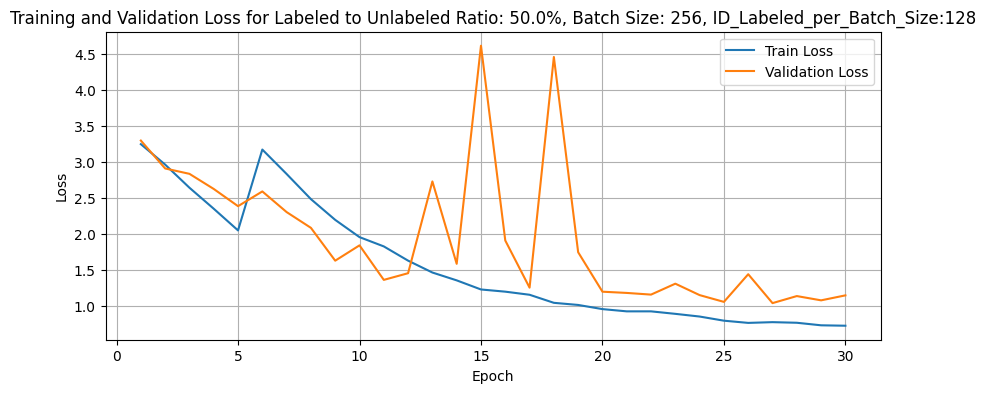

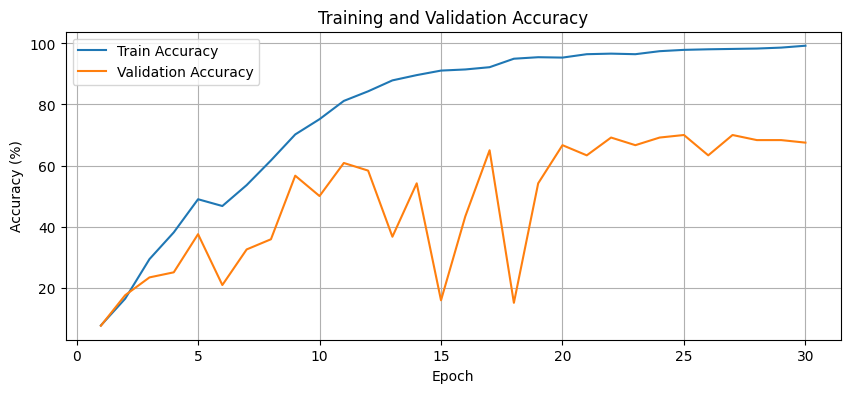

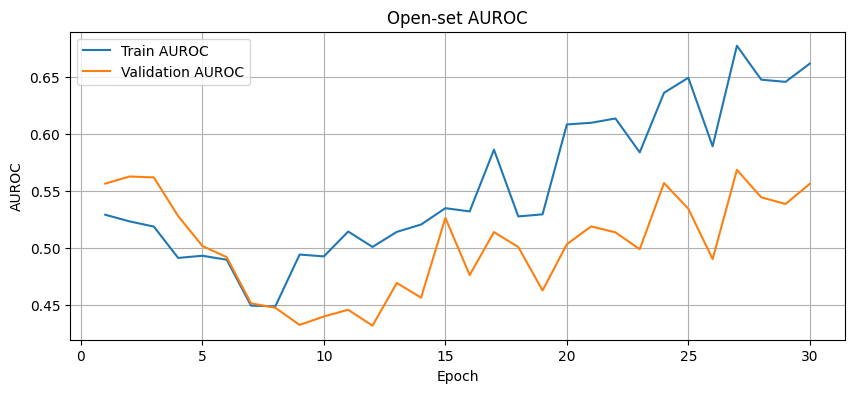

🎉 Training complete.


In [1]:
main(labeled_ratio_given=0.1, batchSize=64, ID_Labeled_Size=6)
main(labeled_ratio_given=0.1, batchSize=128, ID_Labeled_Size=64)
main(labeled_ratio_given=0.5, batchSize=128, ID_Labeled_Size=64)
main(labeled_ratio_given=0.5, batchSize=256, ID_Labeled_Size=128)
